In [ ]:
#retested dallas on this program it is good. 

In [1]:
!pip install tensorflow-addons
!pip install pyarrow
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.6 MB/s eta 0:00:00a 0:00:01
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 28.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.3 MB/s eta 0:00:0000:0100:01


In [1]:
import os
from datetime import datetime as dt

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pyarrow
#from tensorflow import feature_column
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras import layers
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
import tensorflow_addons as tfa
#import tensorflow_model_analysis as tfma

from keras.models import Model
from keras.models import load_model
from keras.models import Sequential
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers import Input, Conv2D, Conv1D, LSTM, Conv2DTranspose, TimeDistributed, RepeatVector, MaxPooling2D, Concatenate,Dropout, Dense, Reshape, UpSampling2D, Activation, BatchNormalization, LeakyReLU, Input, Flatten, multiply,Embedding


from keras.callbacks import Callback
#import tensorflow.compat.v1 as tf

#import horovod.tensorflow.keras as hvd
from tensorflow.keras import models
#from tensorflow.keras.regularizers import l2
#hvd.init()

from numpy.random import seed
# tf.random.set_seed(42)
# np.random.seed(42)
import random
# random.seed(42)
from keras import backend as K



#tf.random.set_seed(42)


ModuleNotFoundError: No module named 'tensorflow'

In [2]:
city="Portland" #CHANGE

df2010_2020= pd.read_parquet("/Users/sn/Documents/GEE/"+city+"Pt12Feat_2010-2020.pq", engine='pyarrow')

dfvalid2021 = pd.read_parquet("/Users/sn/Documents/GEE/"+city+"Pt12Feat_2021VALID.pq", engine='pyarrow')
dftesthalf2022 = pd.read_parquet("/Users/sn/Documents/GEE/"+city+"Pt12Feat_2022HALFTEST.pq", engine='pyarrow')


# Inpt2010_2016= pd.read_parquet(/Users/sn/Documents/main datasets/Indpt2010_2016df_selF, engine='pyarrow')
# Inpt2018= pd.read_parquet(/Users/sn/Documents/main datasets/Indpt2018df_selF, engine='pyarrow')
# Inpt2020= pd.read_parquet(/Users/sn/Documents/main datasets/Indpt2020df_selF, engine='pyarrow')

In [3]:

def datasetquality(df):
    duplicate_rows_df = df[df.duplicated()]
    print("number of duplicate rows: ", duplicate_rows_df.shape)
    print(df.isnull().sum())
    print(df.shape)

def preprocess(df):
    df = df.reindex(columns=['time', 'x','y','surface_thermal_radiation_downwards', 'dewpoint_temperature_2m',
       'snow_albedo', 'surface_solar_radiation_downwards', 'surface_runoff',
       'soil_temperature_level_2', 'total_precipitation_hourly',
       'surface_runoff_hourly', 'total_precipitation',
       'lake_total_layer_temperature', 'potential_evaporation_hourly',
       'temperature_2m'])
    
    #converting temp from kelvin to F
    df["temperature_2m"] = 9 / 5 *(df["temperature_2m"] - 273.15) + 32
    #new_temp = round(9 / 5 * (temp - 273.15) + 32, 3)
    df = df.rename({'x': 'lat', 'y': 'long'}, axis=1)
    
    #scaling
    df=df.set_index(["time","lat","long"])
    df.iloc[:, :-1] = MinMaxScaler().fit_transform(df.iloc[:,:-1].values)
    
    return df
    


In [4]:
#for first time only with new datasets:
datasetquality(df2010_2020)
datasetquality(dfvalid2021)
datasetquality(dftesthalf2022)

number of duplicate rows:  (0, 15)
time                                   0
y                                      0
x                                      0
surface_thermal_radiation_downwards    0
dewpoint_temperature_2m                0
snow_albedo                            0
surface_solar_radiation_downwards      0
surface_runoff                         0
soil_temperature_level_2               0
surface_runoff_hourly                  0
total_precipitation                    0
lake_total_layer_temperature           0
potential_evaporation_hourly           0
total_precipitation_hourly             0
temperature_2m                         0
dtype: int64
(96432, 15)
number of duplicate rows:  (0, 15)
time                                   0
y                                      0
x                                      0
surface_thermal_radiation_downwards    0
dewpoint_temperature_2m                0
snow_albedo                            0
surface_solar_radiation_downwards      0
sur

In [5]:
df2010_2020 = preprocess(df2010_2020)
dfvalid2021 = preprocess(dfvalid2021)
dftesthalf2022 = preprocess(dftesthalf2022)

In [6]:

print(df2010_2020.shape)#(96432, 12)
print(dfvalid2021.shape)#(8760, 12)
print(dftesthalf2022.shape)#(4344, 12)


(96432, 12)
(8760, 12)
(4344, 12)


In [7]:
dftesthalf2022.head()#always check as it sometimes does not preprocess

,,,surface_thermal_radiation_downwards,dewpoint_temperature_2m,snow_albedo,surface_solar_radiation_downwards,surface_runoff,soil_temperature_level_2,total_precipitation_hourly,surface_runoff_hourly,total_precipitation,lake_total_layer_temperature,potential_evaporation_hourly,temperature_2m
time,lat,long,,,,,,,,,,,,
2022-01-01 00:00:00,-122.650561,45.550208,0.646535,0.410919,0.580363,0.202917,0.001945,0.040333,0.000077,0.000005,0.044941,0.002615,0.932458,32.843190
2022-01-01 01:00:00,-122.650561,45.550208,0.001483,0.348467,0.574598,0.001264,0.000000,0.040474,0.000006,0.000005,0.000000,0.948662,0.957934,29.059196
2022-01-01 02:00:00,-122.650561,45.550208,0.025339,0.343595,0.572797,0.001264,0.000000,0.040065,0.000006,0.000005,0.000000,0.002415,0.963215,29.825465
2022-01-01 03:00:00,-122.650561,45.550208,0.049050,0.351325,0.571886,0.001264,0.000000,0.039111,0.000006,0.000005,0.000000,0.002297,0.965143,29.350746
2022-01-01 04:00:00,-122.650561,45.550208,0.072254,0.341969,0.570953,0.001264,0.000000,0.037614,0.000006,0.000005,0.000000,0.002172,0.964560,27.451924


In [8]:
look_back=48
look_forward =48
def create_dataset(dataset, look_back, look_forward):
    dataX, dataY = [], []
    for i in range(len(dataset)):
        past_end = i + look_back
        future_end = past_end + look_forward
        if future_end > len(dataset):
                break
        a = dataset.iloc[i:past_end ,:]
        dataX.append(a)
        b= dataset.iloc[past_end:future_end,-1:]
        dataY.append(b)
    TrainX = np.array(dataX)
    TrainY = np.array(dataY)

    return TrainX, TrainY



In [9]:
#this is for Dallas point windows FOR TEST AND VALID DATA ONLY:
Xtest, ytest= create_dataset(dftesthalf2022,48, 48)
testdata=(Xtest,ytest)

Xval, yval= create_dataset(dfvalid2021,48, 48)
valdata=(Xval,yval)

In [10]:
#IF CRASHING, RESTART JUPYTER AND TRY A COUPEL OF TIMES
# CHOOSE : WINDOWED DATASET CREATION FOR TRAIN DATA; CHOOSE ONE ONLY AND COMMENT THE REST:

#IF FOR 11YR TRAIN CHOOSE:
Xtrain, ytrain= create_dataset(df2010_2020,48, 48)
traindata=(Xtrain,ytrain)

# #IF FOR 11YR, 1YR BY 1YR TRAIN, CHOOSE:
# Xtrain, ytrain= create_dataset(Inpt2010_2020,48, 48)
# traindata=(Xtrain,ytrain)


In [11]:
Xtrain.shape#(96337, 48, 12)

(96337, 48, 12)

In [12]:
#custom metric: https://arxiv.org/pdf/2106.09757.pdf; https://www.cawcr.gov.au/projects/verification/verif_web_page.html;
#https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05
#hits: tp
# misses: fn
# false alarms: fp

#IMPORTANT: https://www.researchgate.net/publication/352558898_CIRA_Guide_to_Custom_Loss_Functions_for_Neural_Networks_in_Environmental_Sciences_--_Version_1#pf24
#FOR DIFFERENTIAL LOSSES, USE TF.CLIP: https://stackoverflow.com/questions/44796793/difference-between-tf-clip-by-value-and-tf-clip-by-global-norm-for-rnns-and-how
from keras import backend as K


        
    #return tf.keras.backend.mean(tf.where(cond, mse*(4.0*(y_true-y_pred)), 0.0))

#tf.keras.losses.Huber() is not working([predictions must be <= 1] [Condition x <= y did not hold element-wise:] [x (sequential_13/reshape_13/Reshape:0) = ] [[[0.474825501][0.474994183][0.478659779]]...] [y (Cast_7/x:0) = ] [1]), so:
# def my_huber_loss(y_true, y_pred):   #this also gives error: [predictions must be >= 0] [Condition x >= y did not hold element-wise:] [x (sequential_14/reshape_14/Reshape:0)
  
#     threshold = 1     
#     error = y_true - y_pred     
#     is_small_error = tf.abs(error) <= threshold     
#     small_error_loss = tf.square(error) / 2     
#     big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
#     return tf.where(is_small_error, small_error_loss, big_error_loss)
def f1_loss(y_true, y_pred): # https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric/notebook
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# def accuracy(y_true, y_pred):
    
#     tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
#     tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
#     fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
#     fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    
#     return (tp+tn) / (tp+tn+fp+fn + K.epsilon())

# Loss function with weights based on amplitude of y_true (getting rarer higher values): multiplying (e to the power of 5*y_true) to mse; and getting the mean of that no.from above"IMPORTANT"link
def rare_MSE_weighted(y_true,y_pred):
  return K.mean(tf.multiply(tf.exp(tf.multiply(5.0, y_true)),tf.square(tf.subtract(y_pred, y_true))))

#dual weighted mse: weights points with a large predicted or actual target more heavily https://journals.ametsoc.org/view/journals/atot/38/10/JTECH-D-21-0007.1.xml#s3c2
def dual_weighted_mse(gamma_weight):
  def loss(target_tensor, prediction_tensor):
    return K.mean((K.maximum(K.abs(target_tensor), K.abs(prediction_tensor)) ** gamma_weight) *(prediction_tensor - target_tensor) ** 2)
  return loss
#loss=dual_weighted_mse(gamma_weight=5.) for gamma =5


#custom accuracy: loss=CustomAccuracy() https://github.com/GitMarco27/TMML/blob/main/Notebooks/009_Custom_Loss.ipynb. ; https://towardsdatascience.com/custom-loss-function-in-tensorflow-eebcd7fed17a
class CustomAccuracy(tf.keras.losses.Loss): 
  def __init__(self):
    super().__init__()
  def call(self, y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse / tf.reduce_mean(tf.square(y_true)) - 1

#HAM minimise the errors that happen very often, close to the location of the distribution. It will typically ignore the outliers and focus on the most frequently appearing values.
#can make it even less sensitive to outliers and more focused on the frequently appearing values: https://openforecast.org/adam/non-mle-based-loss-functions.html
def ham(y_true, y_pred):  #MSE is minimised by mean, while MAE is minimised by the median. This means that models estimated using MAE will typically be more conservative
  mae_but_with_sqrt= tf.reduce_mean(tf.math.sqrt(tf.abs(y_true - y_pred)))
  mae_but_with_sqrt = tf.where(tf.math.is_nan(mae_but_with_sqrt), tf.zeros_like(mae_but_with_sqrt), mae_but_with_sqrt)
  return mae_but_with_sqrt #RESULTING IN NAN VALUES FOR THIS AND OTHER METRICS

#F1 score :
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#CRITICAL SUCCESS INDEX/Threat Score;  0 to 1, 0 indicates no skill. Perfect score: 1. It is ccuracy when true negatives have been removed form accuracy
#How well did the forecast "yes" events correspond to the observed "yes" events?; Depends on climatological frequency of events (poorer scores for rarer events) 
def csi(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
  fn = K.sum(K.round(K.clip(y_true *(1- y_pred), 0, 1)))

  denominator = (tp +fp + fn + K.epsilon())
  csi_value = tp/denominator

  return csi_value


def r2(y_true, y_pred): #https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/.  R2 is a normalized version of MSE
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - np.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


#csi as loss:
def csiloss(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)

  denominator = (tp +fp + fn + K.epsilon())
  csi_value = tp/denominator

  return 1.0-csi_value
#GILBERT SKILL SCORE/ Equitable threat score; -1/3 to 1, 0 indicates no skill.  gives a lower score than CSI #DID NOT WORK TypeError: 'Tensor' object is not callable
#How well did the forecast "yes" events correspond to the observed "yes" events (accounting for hits due to chance)?
#for example, it is easier to correctly forecast rain occurrence in a wet climate than in a dry clim
def gss(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)
  
  hits_random_denom = (tp +fp + tn + fn + K.epsilon())
  hits_random = (tp+fn)(tp+fp)/hits_random_denom

  gss_denom = (tp +fp + fn - hits_random + K.epsilon())
  gss_value=tp-hits_random/gss_denom
  gss_value = tf.where(tf.math.is_nan(gss_value), tf.zeros_like(gss_value), gss_value)
  return gss_value

#EXTREME DEPENDENCY SCORE  -1 to 1, 0 indicates no skill. Perfect score: 1 DID NOT WORK
#What is the association between forecast and observed rare events? EDS is independent of bias, so should be presented together with the frequency bias.
def eds(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=1)
  denom = (tp+tn+fp+fn+K.epsilon())
  main_num= 2*np.log(tp+fn/denom)
  main_denom=np.log(tp/denom)
  eds_value = (main_num/(main_denom + K.epsilon()))-1
  return eds_value


#BIAS SCORE/FREQUENCY BIAS: Range: 0 to infinity.  Perfect score: 1.
# Answers the question: How did the forecast frequency of "yes" events compare to the observed frequency of "yes" events?
# Indicates whether the forecast system has a tendency to underforecast (BIAS<1) or overforecast (BIAS>1) events. 
# Does not measure how well the forecast corresponds to the observations, only measures relative frequencies.
def freqbiassc(y_true, y_pred):
  tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  #tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
  fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
  fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
  freqbias_denom=(tp+fn+ K.epsilon())
  freqbias = tp+fp/freqbias_denom
  return freqbias



# def r2(y_true, y_pred): #https://medium.com/@tzjy/10-regression-metrics-data-scientist-must-know-tensorflow-keras-code-included-33f3ad53001c
#     """
#     R^2 (coefficient of determination) regression score function.
#     Best possible score is 1.0, lower values are worse.
#     Args:
#         y_true ([np.array]): test samples
#         y_pred ([np.array]): predicted samples
#     Returns:
#         [float]: R2    
#     """
#     SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
#     SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
#     return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

# #adjusted R2: https://medium.com/@tzjy/10-regression-metrics-data-scientist-must-know-tensorflow-keras-code-included-33f3ad53001c not working due to difference
# def adj_r2(y_true, y_pred):
#     """
#     Adjusted R2 regression score function with default inputs.
#     Best possible score is 1.0, lower values are worse.
#     Args:
#         y_true ([np.array]): test samples
#         y_pred ([np.array]): predicted samples
#     Returns:
#         [float]: adjusted R2
#     """
#     SS_res =  tf.reduce_sum(tf.square(y_true - y_pred), axis=-1)
#     SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true, axis=-1)), axis=-1)
#     return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon())) * (1 - (1 - r2(y_true, y_pred)) * (tf.cast(tf.size(y_true), tf.float32) - 1) / (tf.cast(tf.size(y_true), tf.float32) - tf.cast(tf.rank(y_true), tf.float32) - 1))
#%MATCH:
#WITHIN 1%:
def match1(y_true, y_pred, delta =0.01):
    cond = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon())) < delta
    matches = tf.where(cond, 1,0)
    return K.sum(matches)/K.sum(len(matches))
    
#WITHIN 2%:
def match2(y_true, y_pred, delta =0.02):
    cond = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon())) < delta
    matches = tf.where(cond, 1,0)
    return K.sum(matches)/K.sum(len(matches))  

#WITHIN 3%:
def match3(y_true, y_pred, delta =0.03):
    cond = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon())) < delta
    matches = tf.where(cond, 1,0)
    return K.sum(matches)/K.sum(len(matches))

#WITHIN 5%:
def match5(y_true, y_pred, delta =0.05):
    cond = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon())) < delta
    matches = tf.where(cond, 1,0)
    return K.sum(matches)/K.sum(len(matches))


def match01loss(delta):
    def matchloss(y_true, y_pred):#DID NOT WORK
        condition = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon()))
        #matches = tf.where(tf.less(condition,delta), tf.ones_like(y_pred), tf.zeros_like(y_pred))
        #matches = K.switch((tf.less(condition,delta)), tf.ones_like(condition), tf.zeros_like(condition))
        matches = K.switch((condition<delta), tf.zeros_like(condition),tf.ones_like(condition))
        #matches = tf.cast(matches, dtype=y_pred.dtype)
        return tf.reduce_mean(matches)
    return matchloss

# def match1loss(y_true, y_pred):#with or without AND: got 0 matches
#     condition= ((tf.abs(y_true-y_pred))/(y_true+K.epsilon()))
#     if (condition<=0.01) is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)
#     elif (condition<=0.02) is True and (condition>0.01) is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*0.001)
#     elif (condition<=0.03) is True and (condition>0.02) is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*0.01)
#     elif (condition<=0.05) is True and (condition>0.03) is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*0.1)
#     else:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    
# def match1loss(y_true, y_pred):#got 0 matches with directly placing the condition in if statements
#     condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
#     condition1= condition<=0.01
#     condition2= condition<=0.02 and condition>0.01
#     condition3= condition<=0.03 and condition>0.02
#     condition5= condition<=0.05 and condition>0.03
    
    
#     if condition1 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)
#     elif condition2 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*0.001)
#     elif condition3 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*0.01)
#     elif condition5 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*0.1)
#     else:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*50)

# lower_tensor = tf.greater(y_pred, 0.01)
# upper_tensor = tf.less_equal(y_pred, 0.2)
# in_range = tf.logical_and(lower_tensor, upper_tensor)
# # tf.where is (cond, tensor if cond is true, tensor if cond is false)
# y_pred_w_ones = tf.where(in_range, tf.ones_like(y_pred), y_pred)

def matchMAPEloss(y_true, y_pred):
    MAPE=tf.keras.losses.MeanAbsolutePercentageError()
    greaterthan1 = tf.greater(MAPE, 1.0)
    lessthan2 = tf.less_equal(MAPE, 2.0)
    cond_range1_2 = tf.logical_and(greaterthan1, lessthan2)
    greaterthan2 = tf.greater(MAPE, 2.0)
    lessthan3 = tf.less_equal(MAPE, 3.0)
    cond_range2_3 = tf.logical_and(greaterthan2, lessthan3)
    greaterthan3 = tf.greater(MAPE, 3.0)
    lessthan5 = tf.less_equal(MAPE, 5.0)
    cond_range3_5 = tf.logical_and(greaterthan3, lessthan5)
    # tf.where is (cond, tensor if cond is true, tensor if cond is false)
    y_pred_w_ones = tf.where(in_range, tf.ones_like(y_pred), y_pred)

def match1loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= ((y_true-y_pred))/(y_true+K.epsilon())
    condition1= condition<=0.01 and condition >=-0.01
    condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
    condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
    condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if condition1 is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))#exactly like in T17
    elif condition2 is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*10)
    elif condition3 is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*100)
    elif condition5 is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*1000)
    else:
        return tf.reduce_mean((tf.abs(y_true-y_pred))*10000)
    
def match1_2loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*0.001)
    elif (condition>0.01 and condition<=0.02) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition)
    elif (condition>0.02 and condition<=0.03) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*100)
    elif (condition>0.03 and condition<=0.05) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*10000)
    else:
        return tf.reduce_mean(condition*1000000)
    
def match1_3loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
    #MAE=tf.keras.losses.MeanAbsoluteError()
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.keras.losses.MeanAbsoluteError()*(tf.reduce_mean(condition)*0.001)
    elif (condition>0.01 and condition<=0.02) is True:
        return tf.keras.losses.MeanAbsoluteError()*(tf.reduce_mean(condition))
    elif (condition>0.02 and condition<=0.03) is True:
        return tf.keras.losses.MeanAbsoluteError()*(tf.reduce_mean(condition)*100)
    elif (condition>0.03 and condition<=0.05) is True:
        return tf.keras.losses.MeanAbsoluteError()*(tf.reduce_mean(condition)*10000)
    else:
        return tf.reduce_mean(condition)*1000000 * ((100-y_true)**2)#*MAE(y_true, y_pred)*

def match1_4loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
    #MAE=tf.keras.losses.MeanAbsoluteError()
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*0.001)#*tf.reduce_mean(((tf.abs(y_true-y_pred))*10)**2)
    elif (condition>0.01 and condition<=0.02) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition)
    elif (condition>0.02 and condition<=0.03) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*10)
    elif (condition>0.03 and condition<=0.05) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(condition*100)
    else:
        return tf.reduce_mean(condition*1000)* ((100-y_true)**2)

def match1_5loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
    #MAE=tf.keras.losses.MeanAbsoluteError()
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(((tf.abs(y_true-y_pred))*10)**2)
    elif (condition>0.01 and condition<=0.02) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(((tf.abs(y_true-y_pred))*100)**3)
    elif (condition>0.02 and condition<=0.03) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(((tf.abs(y_true-y_pred))*1000)**4)
    elif (condition>0.03 and condition<=0.05) is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean(((tf.abs(y_true-y_pred))*10000)**5)
    else:
        return tf.reduce_mean(((tf.abs(y_true-y_pred))*100000)**6)* ((100-y_true)**2)
    
    
def match1_1loss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return tf.reduce_mean(condition*0.001)#exactly like in T17
    elif (condition>0.01 and condition<=0.02) is True:
        return tf.reduce_mean(condition)
    elif (condition>0.02 and condition<=0.03) is True:
        return tf.reduce_mean(condition*100)
    elif (condition>0.03 and condition<=0.05) is True:
        return tf.reduce_mean(condition*10000)
    else:
        return tf.reduce_mean(condition*1000000) 

def match1_MAPEloss(y_true, y_pred):#got 0 matches (NAN) even without using tf.abs in condition,with directly placing the condition in if statements
    condition= (tf.abs(y_true-y_pred))/(y_true+K.epsilon())
    MAPE= tf.keras.losses.MeanAbsolutePercentageError()
#     condition1= condition<=0.01 and condition >=-0.01
#     condition2= condition<=0.02 and condition >=-0.02 and condition>0.01 and condition<-0.01
#     condition3= condition<=0.03 and condition >=-0.03 and condition>0.02 and condition<-0.02
#     condition5= condition<=0.05 and condition >=-0.05 and condition>0.03 and condition<-0.03
    if (condition<=0.01) is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
        return MAPE(y_true, y_pred)*tf.reduce_mean(condition*0.001)#exactly like in T17
    elif (condition>0.01 and condition<=0.02) is True:
        return MAPE(y_true, y_pred)*tf.reduce_mean(condition)
    elif (condition>0.02 and condition<=0.03) is True:
        return MAPE(y_true, y_pred)*tf.reduce_mean(condition*100)
    elif (condition>0.03 and condition<=0.05) is True:
        return MAPE(y_true, y_pred)*tf.reduce_mean(condition*10000)
    else:
        return tf.reduce_mean(condition*1000000)
    
def match5loss(y_true, y_pred):#got 0 matches (NAN) (with or without tf.abs in condition) with directly placing the condition in if statements
    condition= ((y_true-y_pred)/(y_true+K.epsilon()))
    MAPE= tf.keras.losses.MeanAbsolutePercentageError()
    #MAPE = tf.cast(MAPE, dtype=condition.dtype)
    if (condition<0.05 and condition >-0.05) is True:
        
        return MAPE(y_true, y_pred)*tf.reduce_mean(condition*0.1)
    
    else:
        return MAPE(y_true, y_pred)#tf.reduce_mean(condition*100)

def matchlikeT17(y_true, y_pred):
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > 0.05
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.05
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)

    
#     if condition1 is True:#just tf.reduce_mean((tf.abs(y_true-y_pred))) with or without *numbers did not work
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
#     elif condition2 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*10)
#     elif condition3 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*100)
#     elif condition5 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*1000)
#     else:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*10000)

#     if condition1 is True:#directly multiplying with tf loss did not work
#         return tf.reduce_mean((tf.abs(y_true-y_pred))/(y_true+K.epsilon())
#     elif condition2 is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))/(y_true+K.epsilon())*10
#     elif condition3 is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))/(y_true+K.epsilon())*100
#     elif condition5 is True:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))/(y_true+K.epsilon())*1000
#     else:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*10000
    
    
#     if condition1 is True:#directly multiplying with tf loss did not work
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
#     elif condition2 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*10)
#     elif condition3 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*100)
#     elif condition5 is True:
#         return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*1000)
#     else:
#         return tf.reduce_mean((tf.abs(y_true-y_pred))*10000)
        
# #     matches=tf.where(tf.less(condition,delta),1.0, 0.0)
#     matches=tf.where(tf.less(condition,delta), tf.ones_like(y_pred), tf.zeros_like(y_pred))
#     return tf.reduce_mean(matches)
#     #return 1.0/tf.reduce_mean(tf.reduce_sum(matches)/tf.reduce_sum(len(matches))) , tf.ones_like(y_pred), tf.zeros_like(y_pred)
#     #matches = tf.where(cond, 1.0,0.0)
#     #matches = tf.keras.backend.switch(cond, 1.0,0.0)
#     matches = tf.cast(matches, dtype=y_pred.dtype)
# #     sum_matches = K.sum(matches)
#     sum_matches = tf.reduce_sum(matches)
#     sum_matches = tf.cast(sum_matches, dtype=y_pred.dtype)
#     len_matches = tf.size(matches)
#     len_matches = tf.cast(len_matches, dtype=y_pred.dtype)
#     #percent_matches = tf.reduce_mean(sum_matches/len_matches)#tf.reduce_mean did not make a difference
#     percent_matches = tf.divide(sum_matches,len_matches)
#     #percent_matches = tf.cast(percent_matches, dtype=y_pred.dtype)#MADE NO DIFF
# #     return tf.reduce_mean(1.0-percent_matches)#1- also didn't work; #tf.reduce_mean did not make a difference
#     losses= tf.divide(1.0,percent_matches)
#     #losses = tf.cast(losses, dtype=y_pred.dtype)#MADE NO DIFF
#     return losses


#whenever tf.keras.backend.switch is used, the error : 'float' object has no attribute 'shape'
#whenever tf.where is used, the error but at the return line: TypeError: `x` and `y` must have the same dtype, got tf.float32 != tf.int32.
# and does not depnd on whether is I use 1 or 1.0 in return line
#above 2 got resolved but now error is ValueError: No gradients provided for any variable:

def match1tfloss(y_true, y_pred, delta =0.01):
    cond=tf.less_equal(keras.losses.MeanAbsolutePercentageError(),delta)
    matches = tf.where(cond, 1.0,0.0)
    #matches = tf.keras.backend.switch(cond, 1.0,0.0)
    matches = tf.cast(matches, dtype=y_pred.dtype)
#     sum_matches = K.sum(matches)
    sum_matches = tf.reduce_sum(matches)
    sum_matches = tf.cast(sum_matches, dtype=y_pred.dtype)
    len_matches = tf.size(matches)
    len_matches = tf.cast(len_matches, dtype=y_pred.dtype)
    percent_matches = sum_matches/len_matches
    return 1.0/percent_matches#1- also didn't work

def match10loss(y_true, y_pred, delta =0.01):#DID NOT WORK
    def match01(y_true, y_pred, delta =0.01):
        cond = ((tf.abs(y_true-y_pred))/(y_true+K.epsilon())) < delta
        matches = tf.where(cond, 1,0)
        return 1.0/tf.reduce_mean(tf.reduce_sum(matches)/tf.reduce_sum(len(matches)))
    return match01#1- also didn't work

# def matchloss(y_true, y_pred):
#     return 10-(match1(y_true, y_pred, delta =0.01)+match2(y_true, y_pred, delta =0.02)+match3(y_true, y_pred, delta =0.03)+match5(y_true, y_pred, delta =0.05))


#MATTHEWS CORRELATION https://towardsdatascience.com/three-ways-to-use-custom-validation-metrics-in-tf-keras-tf2-bb9c40a3076
def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def RMSE(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred-y_true))
    rmse = tf.math.sqrt(mse)
    return rmse
def accuracy(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    
    return (tp+tn) / (tp+tn+fp+fn + K.epsilon())


def threshold_loss(y_true, y_pred, delta=0.01):
    mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**6)
    elif condneg is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**2)
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.01)
    
    
def threshold3_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**9000)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred)**6)
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**0.01)
        
    #return tf.keras.backend.mean(tf.where(cond, mse*(4.0*(y_true-y_pred)), 0.0))
    
def threshold4_loss(y_true, y_pred, delta=0.01):#VERY POOR RESULTS acc 5 x10-7
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    condzero = ((y_true-y_pred)/(y_true+K.epsilon())) == 0.0000
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**900)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred)**6)
    elif condzero is True:
        return -15
    else: 
        return tf.keras.backend.mean((tf.abs((y_true-y_pred)/(y_true+K.epsilon())))**2)
    
def threshold5_loss(y_true, y_pred, delta=0.01):#got the exact same results as threshold_loss
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.01
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**900)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred)**6)
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)

def threshold2_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.01)
    
def threshold6_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*50)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)
    
# def threshold12_loss(y_true, y_pred, delta=0.01):
#     #mse= tf.abs(tf.square(y_true - y_pred))
#     condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
#     #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
#     condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
#     if condpos is True:
#         return tf.keras.backend.mean((tf.abs(y_true-y_pred))**50)
#     elif condneg is True:
#         return tf.keras.backend.mean(tf.abs(y_true-y_pred))
#     else: 
#         return tf.keras.backend.mean((tf.abs(y_true-y_pred))**0.001)

def threshold12_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.001)
    

def threshold13_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)
    
def threshold14_loss(y_true, y_pred, delta=0.05):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.05
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred)))
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)
def threshold15_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.keras.backend.mean((tf.abs(y_true-y_pred)))
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.keras.backend.mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)
    

    
    
#tf.keras.backend.mean((y_true - mae))
def threshold16_loss(y_true, y_pred, delta=0.02):
    mae= tf.keras.losses.MeanAbsoluteError()
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return mae*(tf.reduce_mean((y_true - mae)))
    elif condneg is True:
        return mae*tf.reduce_mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)
    
def threshold17_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)

def threshold18_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))#*5 made it really bad
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.01)

def threshold19_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.001)
    
def threshold20_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**5)
    else: 
        return tf.reduce_mean((tf.abs(y_true-y_pred))*0.0001)
    #tf.keras.losses.MeanAbsoluteError()*0.0001 or f.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**0.0001did not work
def threshold21_loss(y_true, y_pred, delta=0.02):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred)))
    else: 
        return tf.keras.losses.MeanAbsoluteError()*tf.reduce_mean((tf.abs(y_true-y_pred))*0.1)
    
    
    
def threshold7_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred)*5)
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.0001)
    
def threshold8_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred)))
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred)*0.1)
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.00001)
    
def threshold9_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.max((tf.abs(y_true-y_pred))**50)
    elif condneg is True:
        return tf.keras.backend.max(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.max((tf.abs(y_true-y_pred))*0.001)
    
def threshold10_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    if condpos is True:
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))**90)
    elif condneg is True:
        return tf.keras.backend.mean(tf.abs(y_true-y_pred))
    else: 
        return tf.keras.backend.mean((tf.abs(y_true-y_pred))*0.00001)

# def threshold11_loss(y_true, y_pred, delta=0.01):COMPLETE FAIL WITH 0 MATCHED; also tf.keras.backend.rnn failed
#     #mse= tf.abs(tf.square(y_true - y_pred))
#     condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
#     #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
#     condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
#     if condpos is True:
#         return tf.keras.backend.prod((tf.abs(y_true-y_pred))**50)
#     elif condneg is True:
#         return tf.keras.backend.prod(tf.abs(y_true-y_pred))
#     else: 
#         return tf.keras.backend.prod((tf.abs(y_true-y_pred))*0.0001)
# def MAD(y_true, y_pred):   #mean absolute deviation
#    mean =  tf.reduce_mean((y_true - y_pred))
#    mad = tf.reduce_mean((y_true - mean)
#    return(mad)
#FOR MATCH1 AND 2, THRESHOLD 6 BEST, FOR MATCH 3, 5 THRESHOLD 2 BEST
def threshold11_loss(y_true, y_pred, delta=0.01):
    #mse= tf.abs(tf.square(y_true - y_pred))
    condpos = ((y_true-y_pred)/(y_true+K.epsilon())) > delta
    #condneutral = ((y_true-y_pred)/(y_true+K.epsilon())) < delta & ((y_true-y_pred)/(y_true+K.epsilon())) > -0.02
    condneg = ((y_true-y_pred)/(y_true+K.epsilon())) < -0.02
    mae = tf.keras.backend.mean((tf.abs(y_true-y_pred)))
    if condpos is True:
#         mae = tf.keras.backend.mean((tf.abs(y_true-y_pred)))
        return tf.keras.backend.mean((y_true - mae)**50)
    elif condneg is True:
        return tf.keras.backend.mean((y_true - mae))#mean absolute deviation
    else: 
        return tf.keras.backend.mean((y_true - mae)*0.0001)

def pearson_r(x, y):

   # Compute correlation matrix
   corr_mat = np.corrcoef(x, y)

   # Return entry [0,1]
   return corr_mat[0,1]

#custom loss for rare events:https://stackoverflow.com/questions/55764130/keras-custom-loss-with-one-of-the-features-used-and-a-condition
def custom_rareEvents(data, y_pred):
        y_true = data[:, 0]
        d = data[:, 1]

        lnYTrue = KB.switch(KB.equal(y_true, 0), KB.zeros_like(y_true), KB.log(y_true))
        lnYPred = KB.switch(KB.equal(y_pred, 0), KB.zeros_like(y_pred), KB.log(y_pred))
        loss_value = 2 * d * (y_true * lnYTrue - y_true * lnYPred[:, 0] - y_true + y_pred[:, 0])
        return loss_value

In [16]:
%%time 
#just for match experiments, can delete it later, duplicate below:

#11yr train ensemble
OUT_STEPS=48
target_features=1
MAX_EPOCHS = 1000
model = shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM
modelname = " 1lyr_rsF_BiLSTM "
lossname="match1_5loss" #CHANGE
#ORIGINAL USE THIS UNLESS ERROR
listOfRndm13seeds=[42]#, 4, 63, 580, 3297, 883, 2318600, 970036, 7458, 65653, 18436, 1743, 49130]

#listOfRndm13seeds=[42, 4, 63, 580, 3297, 883, 2318600, 970036, 7458, 65653, 18436, 1743, 49130]

#strlistOfRndm13seeds=["4 LSTM", "63 LSTM", "580 LSTM", "3297 LSTM", "883 LSTM", "2318600 LSTM", "970036 LSTM", "7458 LSTM", "65653 LSTM", "18436 LSTM", "1743 LSTM", "49130 LSTM"]

# listofvalarr =[]
# listoftestarr = []
# seedTestmetricsdf= pd.DataFrame()

# bilstmmodel = tf.keras.models.Sequential([
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
#   tf.keras.layers.Dense(OUT_STEPS*target_features, kernel_initializer=tf.initializers.zeros()),
#   tf.keras.layers.Reshape([OUT_STEPS, target_features])])

# shallowLSTMrsF.compile(loss = threshold17_loss,
#             optimizer =tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanSquaredError(),
#                      tf.metrics.MeanAbsoluteError(),
#                      tf.keras.metrics.Accuracy(),
#                      tf.keras.metrics.RootMeanSquaredError(),
#                      tf.keras.metrics.LogCoshError(),
#                      tf.keras.metrics.KLDivergence(),
#                      tf.keras.metrics.CategoricalCrossentropy(),
#                      tfa.metrics.RSquare(),
#                      csi, freqbiassc,f1,ham,match1, match2, match3, match5])

for i in listOfRndm13seeds:
    set_seed(i)
    
    
    checkpoint_path = "/Users/sn/Downloads//Models/training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)



    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=15,#since p18 made it worse with T17 (but not MAE)in lsp_lsp_p15_thresholdloss8-9-11-12-13-14-15-16...20 file
                                                        mode='min', restore_best_weights=True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, #updates at end of each epoch; reload as : model.load_weights(checkpoint_path)
                                                     save_weights_only=False,
                                                     verbose=1)

    model.compile(loss = match1_5loss,#threshold17_loss,#tf.keras.losses.MeanAbsoluteError(),#threshold17_loss,#tf.keras.losses.MeanAbsolutePercentageError(),
            optimizer =tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanSquaredError(),
                     tf.metrics.MeanAbsoluteError(),
                     tf.keras.metrics.Accuracy(),
                     tf.keras.metrics.RootMeanSquaredError(),
                     tf.keras.metrics.LogCoshError(),
                     tf.keras.metrics.KLDivergence(),
                     tf.keras.metrics.CategoricalCrossentropy(),
                     tfa.metrics.RSquare(),
                     csi, freqbiassc,f1,ham,match1, match2, match3, match5])
    history = model.fit(Xtrain,ytrain, epochs=MAX_EPOCHS,
                        validation_data=(Xval,yval),  batch_size=32, callbacks=[early_stopping, cp_callback])#cp_callback, reduceLRplat
    
    #plot_metric(history)
#     seedTestMetricsDict = shallowLSTMrsF.evaluate(x=Xtest,y=ytest, return_dict=True)
#     seedTestmetricsdf = seedTestmetricsdf.append(seedTestMetricsDict, ignore_index=True)
    
    #predval= model.predict(valdata)
    #predvalrs = predval.reshape(predval.shape[0:2])#othewise wont allow to 2D df conversion
    predictions=model.predict(testdata)
    #predtest = predtest.reshape(predtest.shape[0:2])
    #predvaldf = pd.DataFrame(predval)
    #predtestdf = pd.DataFrame(predtest)
#     listofvalarr.append(predval)
#     listoftestarr.append(predtest)
    
    strlabel=str(i)+modelname+lossname
    #model=model
    #predictions=predtest
    graphE(city, strlabel,predictions)
    print(strlabel,"seed completed")

print("12 seedloop completed")
# seedTestmetricsdf["seed"]= listOfRndm12seeds #DO THIS FOR THE VERY FIRST TIME ONLY
# seedTestmetricsdf=seedTestmetricsdf.set_index("seed")#DO THIS FOR THE VERY FIRST TIME ONLY
#seedTestmetricsdf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/seed10Testmetricsdf.pq", compression="gzip")


Epoch 1/1000


2023-04-21 19:39:10.004847: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/sn/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 48, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


 272/3011 [=>............................] - ETA: 1:08 - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - accuracy: 0.0000e+00 - root_mean_squared_error: nan - logcosh: nan - kullback_leibler_divergence: 0.0593 - categorical_crossentropy: 4.3627e-06 - r_square: nan - csi: 0.3321 - freqbiassc: 1530.8511 - f1: 0.9963 - ham: 0.0262 - match1: 0.0000e+00 - match2: 0.0000e+00 - match3: 0.0000e+00 - match5: 0.0000e+00

KeyboardInterrupt: 

In [148]:
#FUNCTION FOR COMPARESEEDDF FOR NEW CITIES:#ONLY FIRST TIME
def makeINITIALCompareseed_Performseeddf(dftesthalf2022,city):
    LVcompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRRLasVegaspoint_half2022.parquet", engine="pyarrow")
    LVperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRRLasVegaspoint_half2022.parquet")

    #To get era5 temp into forecast index:
    tempERA5test=dftesthalf2022[48:]["temperature_2m"]
    tempERA5test = pd.DataFrame(tempERA5test)

    arraylist=[]
    for i in range(4249):#4296 rows-48
        arraylist.extend(np.array(tempERA5test[i:i+48]))

    eradf=pd.DataFrame(arraylist,index=LVcompareseeddf.index)
    ERA5strlabel= 'ERA5 T2m '+city
    eradf.rename(columns={0: ERA5strlabel}, inplace=True)
    
    #to get HRRR; add above ERA to HRRR
    cityHRRRfilename= '/Users/sn/Downloads/nonscaled_preprocesssed_Ind/'+city+'_point_hrrr_t2m_first6Months2022.pq_gz'
    cityseed2022t2m=pd.read_parquet(cityHRRRfilename,engine='pyarrow')#should be 203952 rows × 1 columns
    cityseed2022t2m=cityseed2022t2m[:-2256]
    HRRRstrlabel= 'HRRR T2m '+city
    cityseed2022t2m.rename(columns={'t2m': HRRRstrlabel}, inplace=True)
    cityseed2022t2m[ERA5strlabel]=np.array(eradf[ERA5strlabel])
    cityseed2022t2m = cityseed2022t2m[[ERA5strlabel, HRRRstrlabel]]
    cityseed2022t2m.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

    
    #making performseeddf
    Performseeds =pd.DataFrame(index=LVperformseeddf.index)

    cityseed2022t2m_wo_nan= cityseed2022t2m.dropna()
    era5nonan=np.array(cityseed2022t2m_wo_nan[ERA5strlabel])
    strlabelnonan=np.array(cityseed2022t2m_wo_nan[HRRRstrlabel])

    Performseeds[HRRRstrlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                              keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                              RMSE(era5nonan, strlabelnonan).numpy(), 
                                              threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                              r2(era5nonan, strlabelnonan).numpy(), 
                                              accuracy(era5nonan, strlabelnonan).numpy(), 
                                              match1(era5nonan, strlabelnonan).numpy(), 
                                              match2(era5nonan, strlabelnonan).numpy(), 
                                              match3(era5nonan, strlabelnonan).numpy(), 
                                              match5(era5nonan, strlabelnonan).numpy()]
    Performseeds.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet")
    
    
makeINITIALCompareseed_Performseeddf(dftesthalf2022,city)

In [165]:
#convolutional model:
CONV_WIDTH = 48
OUT_STEPS=48
target_features=1
conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*target_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, target_features])
])

In [166]:
LSTM2lyrsT = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    #tf.keras.layers.Dense
    tf.keras.layers.LSTM(32, return_sequences=True),#tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # Shape => [batch, out_steps*features].
    #tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(OUT_STEPS*target_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, target_features])
])

In [164]:
OUT_STEPS=48
target_features=1

shallowLSTMrsF = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*target_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, target_features])
])

In [172]:
#BILSTM rsT

OUT_STEPS=48
target_features=1


# inputs = keras.Input(shape=(48,34))
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(inputs)
# x = layers.Dense(OUT_STEPS*target_features, kernel_initializer=tf.initializers.zeros())(x)
# outputs = layers.Reshape([OUT_STEPS, target_features])(x)

# shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM = keras.Model(inputs=inputs, outputs=outputs)


shallow2L_1rsT_temp_unscaled_thresholdloss_BiLSTM = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# Given a tensor input, this operation inserts a dimension of size 1 at the dimension index axis of input's shape. 
                                                               # https://www.tensorflow.org/api_docs/python/tf/expand_dims
                      #input_shape=[None]),     # This means that the model can take sequences of any length
  #tf.keras.layers.Lambda(lambda x: x[:, -24:, :]),
  # The windowed_dataset() return two dimensional batches, with the first being the batch size and the second being the number of timesteps 
  # But the RNN expects three dimensions, so the lambda layer, help fix the difference in dimensions, by adding expannding the array by one dimension

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),#32, return_sequences=False

  # input a sequence and don't output it, except for the last one (sequence to vector RNN), which is the default behavior of Keras TF, 
  # otherwise we set the return_sequence=False and we we'll have (sequence to sequence)

  # The output of the layer is three dimensionals [batch_size * number_units(nulber of units in a cell) * overall_steps(number of cells)]

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),#not working if rs=F; needs rs= T
  #tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(OUT_STEPS*target_features,  #***********????? IF THIS SHOULD BE num_features(30) or target_features(1)
                          kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([OUT_STEPS, target_features])
  #tf.keras.layers.Lambda(lambda x: x * 10.0)

  # For example the activation function of the RNN use tanH functino which have values between -1 and 1, 
  # so we multipky the output by 100, so we can have the regular values of our input time series.
])

In [13]:
# #MODEL ORIGINAL 
OUT_STEPS=48
target_features=1


# inputs = keras.Input(shape=(48,34))
# x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False))(inputs)
# x = layers.Dense(OUT_STEPS*target_features, kernel_initializer=tf.initializers.zeros())(x)
# outputs = layers.Reshape([OUT_STEPS, target_features])(x)

# shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM = keras.Model(inputs=inputs, outputs=outputs)


shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# Given a tensor input, this operation inserts a dimension of size 1 at the dimension index axis of input's shape. 
                                                               # https://www.tensorflow.org/api_docs/python/tf/expand_dims
                      #input_shape=[None]),     # This means that the model can take sequences of any length
  #tf.keras.layers.Lambda(lambda x: x[:, -24:, :]),
  # The windowed_dataset() return two dimensional batches, with the first being the batch size and the second being the number of timesteps 
  # But the RNN expects three dimensions, so the lambda layer, help fix the difference in dimensions, by adding expannding the array by one dimension

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),#32, return_sequences=False

  # input a sequence and don't output it, except for the last one (sequence to vector RNN), which is the default behavior of Keras TF, 
  # otherwise we set the return_sequence=False and we we'll have (sequence to sequence)

  # The output of the layer is three dimensionals [batch_size * number_units(nulber of units in a cell) * overall_steps(number of cells)]

  #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),#not working if rs=F; needs rs= T
  #tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(OUT_STEPS*target_features,  #***********????? IF THIS SHOULD BE num_features(30) or target_features(1)
                          kernel_initializer=tf.initializers.zeros()),
  tf.keras.layers.Reshape([OUT_STEPS, target_features])
  #tf.keras.layers.Lambda(lambda x: x * 10.0)

  # For example the activation function of the RNN use tanH functino which have values between -1 and 1, 
  # so we multipky the output by 100, so we can have the regular values of our input time series.
])

Metal device set to: Apple M2


In [74]:
###WARNING NEEDS TO BE CHANGED FOR DIFF CITIES

# LVcompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRRLasVegaspoint_half2022.parquet", engine="pyarrow")
# LVperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRRLasVegaspoint_half2022.parquet")


In [90]:
# city="LasVegas"
# LVcompareseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

# LVperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRR"+city+"point_half2022.parquet", compression="gzip")
                                  

In [14]:

# def graph(strlabel, predictions, model):
#     modelsdf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_diffmodelstfts_HRRRIndpoint_half2022.parquet", engine="pyarrow")
#     performmodelsdf= pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffmodelstfts_HRRRIndpoint_half2022.parquet", engine="pyarrow")
    
#     #predictions=model.predict(testdata)
#     predictions = predictions.reshape(4249,48)
#     predictionsdf =pd.DataFrame(predictions, index=Indpointtestdf.index[48:-47])
#     predictionsdf=predictionsdf.stack()
#     predictionsdf = predictionsdf.to_frame(name=strlabel)
#     predictionsdf=predictionsdf.reset_index()
#     predictionsdf=predictionsdf.drop(["lat","long"], axis =1)
#     predictionsdf.rename( columns={'level_3' :'forecastHr'}, inplace=True )
#     predictionsdf=predictionsdf.set_index(["time","forecastHr"])
#     modelsdf[strlabel]=predictionsdf[strlabel]
    
#     modelsdf_wo_nan= modelsdf.dropna()
#     era5nonan=np.array(modelsdf_wo_nan["era5forecasttemp"])
#     strlabelnonan=np.array(modelsdf_wo_nan[strlabel])
    
#     performmodelsdf[strlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
#                                           keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
#                                           RMSE(era5nonan, strlabelnonan).numpy(), 
#                                           threshold_loss(era5nonan, strlabelnonan).numpy(), 
#                                           r2(era5nonan, strlabelnonan).numpy(), 
#                                           accuracy(era5nonan, strlabelnonan).numpy(), 
#                                           match1(era5nonan, strlabelnonan).numpy(), 
#                                           match2(era5nonan, strlabelnonan).numpy(), 
#                                           match3(era5nonan, strlabelnonan).numpy(), 
#                                           match5(era5nonan, strlabelnonan).numpy()]
#     modelsdf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_diffmodelstfts_HRRRIndpoint_half2022.parquet", compression="gzip")
#     performmodelsdf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffmodelstfts_HRRRIndpoint_half2022.parquet", compression="gzip")
                                  
#     ax=performmodelsdf[6:10].mul(100).plot(kind="bar", figsize=(15,12), width=0.7, fontsize=14)# log=True,
#     ax.legend(fontsize=4)
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'
        
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  #tf.set_random_seed(seed)

def plot_metric(history):
    train_metrics = history.history["loss"]
    val_metrics = history.history['val_loss']
    epochs = range(1, len(val_metrics) + 1)
    plt.plot(epochs, train_metrics, label="train-loss")
    plt.plot(epochs, val_metrics, label="val-loss")
    plt.title('Training and validation '+ "T17loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    #plt.legend(["train_loss", 'val_loss"])
    plt.legend()
    plt.show()
############################################################################################
# #this section for first time only
# dallasseeddf=comparedallasdf.iloc[:,:2]
# # seeddf["42"]=modelsdf["lsp_lsp_selF_T17p15_11yrtrainReord"]
# dallasseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasseeddf.pq", compression="gzip")
# dallasperformseeddf =compareDallasPerform.iloc[:,:1]
# # performseeddf["HRRR"]=performmodelsdf["HRRRtmp"]
# # performseeddf["42"]=performmodelsdf["lsp_lsp_selF_T17p15_11yrtrainReord"]
# dallasperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasperformseeddf.pq", compression="gzip")
# ##############################################################################################################

def graphE(city, strlabel, predictions):
    citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
    cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet")
#     citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasseeddf.pq", engine="pyarrow")
#     cityperformseeddf= pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasperformseeddf.pq", engine="pyarrow")
    

    #predictions=model.predict(testdata) #already included in ensemble code
    predictions = predictions.reshape(4249,48)
    predictionsdf =pd.DataFrame(predictions, index=dftesthalf2022.index[48:-47])
    predictionsdf=predictionsdf.stack()
    predictionsdf = predictionsdf.to_frame(name=strlabel+city)
    predictionsdf=predictionsdf.reset_index()
    predictionsdf=predictionsdf.drop(["lat","long"], axis =1)
    predictionsdf.rename( columns={'level_3' :'Forecast Hr'}, inplace=True )
    predictionsdf=predictionsdf.set_index(["time","Forecast Hr"])
    citycompareseeddf[strlabel+city]=predictionsdf[strlabel+city]
    
    citycompareseeddf_wo_nan= citycompareseeddf.dropna()
    era5nonan=np.array(citycompareseeddf_wo_nan["ERA5 T2m "+city])
    strlabelnonan=np.array(citycompareseeddf_wo_nan[strlabel+city])
    
    cityperformseeddf[strlabel+city]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                          keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                          RMSE(era5nonan, strlabelnonan).numpy(), 
                                          threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                          r2(era5nonan, strlabelnonan).numpy(), 
                                          accuracy(era5nonan, strlabelnonan).numpy(), 
                                          match1(era5nonan, strlabelnonan).numpy(), 
                                          match2(era5nonan, strlabelnonan).numpy(), 
                                          match3(era5nonan, strlabelnonan).numpy(), 
                                          match5(era5nonan, strlabelnonan).numpy()]
    citycompareseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

    cityperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", compression="gzip")
#     citycompareseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasseeddf.pq", compression="gzip")

#     cityperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasperformseeddf.pq", compression="gzip")
                                                         
#     ax=performseeddf[6:10].mul(100).plot(kind="bar", figsize=(15,12), width=0.7, fontsize=14)# log=True,
#     ax.legend(fontsize=12)
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'
        

In [15]:
#compile_and_fit 

target_features=1
#MAX_EPOCHS = 20
#tf.random.set_seed(42)


checkpoint_path = "/Users/sn/Downloads//Models/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,#since p18 made it worse with T17 (but not MAE)in lsp_lsp_p15_thresholdloss8-9-11-12-13-14-15-16...20 file
                                                    mode='min', restore_best_weights=True)
  
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, #updates at end of each epoch; reload as : model.load_weights(checkpoint_path)
                                                 save_weights_only=False,
                                                 verbose=1)
#comparedf= pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/ERA5-RRR-modelpredictions_Indpoint_half2022.parquet", engine ="pyarrow")

#Explainerdf=comparedf.iloc[:,0:2]
MAX_EPOCHS = 1000

# shallowLSTMrsF.compile(loss = threshold17_loss, #tf.keras.losses.MeanAbsoluteError()                       #tf.keras.losses.Huber(delta=1),   #TRY CustomAccuracy() and Huber loss (delta =1); tf.losses.LogCosh() slightly worse performance in map;csiloss did not work; tf.keras.losses.KLDivergence()
#                 optimizer =tf.keras.optimizers.Adam(),
#                 #optimizer=hvd.DistributedOptimizer(tf.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999,
#                #epsilon=None, decay=0.0, amsgrad=False)),                           #loss = RobustAdaptativeLoss().loss, metric: RobustAdaptativeLoss().alpha
#                 metrics=[tf.keras.metrics.MeanSquaredError(),
#                          tf.metrics.MeanAbsoluteError(),
#                          tf.keras.metrics.Accuracy(),
#                          tf.keras.metrics.RootMeanSquaredError(),
#                          #tf.keras.metrics.Precision(), #THESE ARE THE ONES CAUSING SHAPE ERRORS!
#                          #tf.keras.metrics.Recall(),
#                          tf.keras.metrics.LogCoshError(),
#                          tf.keras.metrics.KLDivergence(),
#                          tf.keras.metrics.CategoricalCrossentropy(),
#                          tfa.metrics.RSquare(),
#                          #tfa.metrics.MatthewsCorrelationCoefficient(),
#                          #tfa.metrics.HammingLoss(),
#                          #RobustAdaptativeLoss().alpha,
#                          #tfma.metrics.MatthewsCorrelationCoefficient(),
#                          #tfma.metrics.ThreatScore(),
#                          csi, freqbiassc,f1,ham,match1, match2, match3, match5 #,matthews_correlation, ham #ham if not being used as loss
#                          ])


In [170]:
#diff models
#compile_and_fit 

target_features=1
#MAX_EPOCHS = 20
tf.random.set_seed(42)
OUT_STEPS=48
target_features=1
MAX_EPOCHS = 1000

checkpoint_path = "/Users/sn/Downloads//Models/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)



early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min', restore_best_weights=True)
  
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, #updates at end of each epoch; reload as : model.load_weights(checkpoint_path)
                                                 save_weights_only=False,
                                                 verbose=1)
#comparedf= pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/ERA5-RRR-modelpredictions_Indpoint_half2022.parquet", engine ="pyarrow")

#Explainerdf=comparedf.iloc[:,0:2]
MAX_EPOCHS = 1000
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=15,
                                                    mode='min', restore_best_weights=True)
set_seed(42)

In [ ]:
%%time
#diff models 
#this has to work for rest of it
listOfModels =[shallow2L_1rsT_temp_unscaled_thresholdloss_BiLSTM,
conv_model, LSTM2lyrsT, shallowLSTMrsF]

listOfModelsSTR =["shallow1L_1rsT_temp_unscaled_thresholdloss_BiLSTM",
"conv_model", "LSTM2lyrsT", "shallowLSTMrsF"]

for mod in listOfModels:
    mod.compile(loss = threshold17_loss,                        #tf.keras.losses.Huber(delta=1),   #TRY CustomAccuracy() and Huber loss (delta =1); tf.losses.LogCosh() slightly worse performance in map;csiloss did not work; tf.keras.losses.KLDivergence()
                optimizer =tf.keras.optimizers.Adam(),
                #optimizer=hvd.DistributedOptimizer(tf.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999,
               #epsilon=None, decay=0.0, amsgrad=False)),                           #loss = RobustAdaptativeLoss().loss, metric: RobustAdaptativeLoss().alpha
                metrics=[tf.keras.metrics.MeanSquaredError(),
                         tf.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.Accuracy(),
                         tf.keras.metrics.RootMeanSquaredError(),
                         #tf.keras.metrics.Precision(), #THESE ARE THE ONES CAUSING SHAPE ERRORS!
                         #tf.keras.metrics.Recall(),
                         tf.keras.metrics.LogCoshError(),
                         tf.keras.metrics.KLDivergence(),
                         tf.keras.metrics.CategoricalCrossentropy(),
                         tfa.metrics.RSquare(),
                         #tfa.metrics.MatthewsCorrelationCoefficient(),
                         #tfa.metrics.HammingLoss(),
                         #RobustAdaptativeLoss().alpha,
                         #tfma.metrics.MatthewsCorrelationCoefficient(),
                         #tfma.metrics.ThreatScore(),
                         csi, freqbiassc,f1,ham,match1, match2, match3, match5 #,matthews_correlation, ham #ham if not being used as loss
                         ])
    history = mod.fit(Xtrain,ytrain, epochs=MAX_EPOCHS,
                        validation_data=(Xval,yval),  batch_size=32, callbacks=[early_stopping, cp_callback])
    mod.save('/Users/sn/Documents/trained models/NewModels/AlbanyNYpointlongp15train_scratchdata_NOTROUNDED_T17LOSS_SELECTEDfeatures_'+listOfModelsSTR[listOfModels.index(mod)]+'_48-48_minmax_hrmodel.h5')
    strlabel = city+"T17loss "+listOfModelsSTR[listOfModels.index(mod)] #used twice in this box of code
    predictions=mod.predict(testdata)
    graphE(city, strlabel, predictions)

In [20]:
%%time 
#11yr train ensemble
OUT_STEPS=48
target_features=1
MAX_EPOCHS = 1000
model = shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM
modelname = " 1lyr_rsF_BiLSTM "
lossname="match1_5loss" #CHANGE
#ORIGINAL USE THIS UNLESS ERROR
listOfRndm13seeds=[42]#, 4, 63, 580, 3297, 883, 2318600, 970036, 7458, 65653, 18436, 1743, 49130]

#listOfRndm13seeds=[42, 4, 63, 580, 3297, 883, 2318600, 970036, 7458, 65653, 18436, 1743, 49130]

#strlistOfRndm13seeds=["4 LSTM", "63 LSTM", "580 LSTM", "3297 LSTM", "883 LSTM", "2318600 LSTM", "970036 LSTM", "7458 LSTM", "65653 LSTM", "18436 LSTM", "1743 LSTM", "49130 LSTM"]

# listofvalarr =[]
# listoftestarr = []
# seedTestmetricsdf= pd.DataFrame()

# bilstmmodel = tf.keras.models.Sequential([
#   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
#   tf.keras.layers.Dense(OUT_STEPS*target_features, kernel_initializer=tf.initializers.zeros()),
#   tf.keras.layers.Reshape([OUT_STEPS, target_features])])

# shallowLSTMrsF.compile(loss = threshold17_loss,
#             optimizer =tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanSquaredError(),
#                      tf.metrics.MeanAbsoluteError(),
#                      tf.keras.metrics.Accuracy(),
#                      tf.keras.metrics.RootMeanSquaredError(),
#                      tf.keras.metrics.LogCoshError(),
#                      tf.keras.metrics.KLDivergence(),
#                      tf.keras.metrics.CategoricalCrossentropy(),
#                      tfa.metrics.RSquare(),
#                      csi, freqbiassc,f1,ham,match1, match2, match3, match5])

for i in listOfRndm13seeds:
    set_seed(i)
    
    
    checkpoint_path = "/Users/sn/Downloads//Models/training_1/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)



    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=15,#since p18 made it worse with T17 (but not MAE)in lsp_lsp_p15_thresholdloss8-9-11-12-13-14-15-16...20 file
                                                        mode='min', restore_best_weights=True)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, #updates at end of each epoch; reload as : model.load_weights(checkpoint_path)
                                                     save_weights_only=False,
                                                     verbose=1)

    model.compile(loss = match1_5loss,#threshold17_loss,#tf.keras.losses.MeanAbsoluteError(),tf.keras.losses.MeanAbsolutePercentageError(),
            optimizer =tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanSquaredError(),
                     tf.metrics.MeanAbsoluteError(),
                     tf.keras.metrics.Accuracy(),
                     tf.keras.metrics.RootMeanSquaredError(),
                     tf.keras.metrics.LogCoshError(),
                     tf.keras.metrics.KLDivergence(),
                     tf.keras.metrics.CategoricalCrossentropy(),
                     tfa.metrics.RSquare(),
                     csi, freqbiassc,f1,ham,match1, match2, match3, match5])
    history = model.fit(Xtrain,ytrain, epochs=MAX_EPOCHS,
                        validation_data=(Xval,yval),  batch_size=32, callbacks=[early_stopping, cp_callback])#cp_callback, reduceLRplat
    
    #plot_metric(history)
#     seedTestMetricsDict = shallowLSTMrsF.evaluate(x=Xtest,y=ytest, return_dict=True)
#     seedTestmetricsdf = seedTestmetricsdf.append(seedTestMetricsDict, ignore_index=True)
    
    #predval= model.predict(valdata)
    #predvalrs = predval.reshape(predval.shape[0:2])#othewise wont allow to 2D df conversion
    predictions=model.predict(testdata)
    #predtest = predtest.reshape(predtest.shape[0:2])
    #predvaldf = pd.DataFrame(predval)
    #predtestdf = pd.DataFrame(predtest)
#     listofvalarr.append(predval)
#     listoftestarr.append(predtest)
    
    strlabel=str(i)+modelname+lossname
    #model=model
    #predictions=predtest
    graphE(city, strlabel,predictions)
    print(strlabel,"seed completed")

print("12 seedloop completed")
# seedTestmetricsdf["seed"]= listOfRndm12seeds #DO THIS FOR THE VERY FIRST TIME ONLY
# seedTestmetricsdf=seedTestmetricsdf.set_index("seed")#DO THIS FOR THE VERY FIRST TIME ONLY
#seedTestmetricsdf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/seed10Testmetricsdf.pq", compression="gzip")


Epoch 1/1000


2023-04-21 13:23:35.521359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-21 13:23:35.681786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-21 13:23:35.694965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-21 13:23:35.966860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-21 13:23:35.980281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  94/3011 [..............................] - ETA: 1:56 - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - accuracy: 0.0000e+00 - root_mean_squared_error: nan - logcosh: nan - kullback_leibler_divergence: 0.0000e+00 - categorical_crossentropy: 4.3513e-06 - r_square: nan - csi: 0.3333 - freqbiassc: 1536.5001 - f1: 1.0000 - ham: 0.0000e+00 - match1: 0.0000e+00 - match2: 0.0000e+00 - match3: 0.0000e+00 - match5: 0.0000e+00

KeyboardInterrupt: 

In [51]:
citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", engine="pyarrow")
citycompareseeddf.columns

Index(['ERA5 T2m Portland', 'HRRR T2m Portland', '4 1lyr_rsF_BiLSTMPortland',
       '63 1lyr_rsF_BiLSTMPortland', '580 1lyr_rsF_BiLSTMPortland',
       '3297 1lyr_rsF_BiLSTMPortland', '883 1lyr_rsF_BiLSTMPortland',
       '2318600 1lyr_rsF_BiLSTMPortland', '970036 1lyr_rsF_BiLSTMPortland',
       '7458 1lyr_rsF_BiLSTMPortland', '65653 1lyr_rsF_BiLSTMPortland',
       '18436 1lyr_rsF_BiLSTMPortland', '1743 1lyr_rsF_BiLSTMPortland',
       '49130 1lyr_rsF_BiLSTMPortland', '42 1lyr_rsF_BiLSTMPortland',
       ' 1lyr_rsF_BiLSTMEnsemble Avg13Portland',
       '42 1lyr_rsF_BiLSTM MAEPortland', '4 1lyr_rsF_BiLSTM MAEPortland',
       '63 1lyr_rsF_BiLSTM MAEPortland', '580 1lyr_rsF_BiLSTM MAEPortland',
       '3297 1lyr_rsF_BiLSTM MAEPortland', '883 1lyr_rsF_BiLSTM MAEPortland',
       '2318600 1lyr_rsF_BiLSTM MAEPortland',
       '970036 1lyr_rsF_BiLSTM MAEPortland',
       '7458 1lyr_rsF_BiLSTM MAEPortland', '65653 1lyr_rsF_BiLSTM MAEPortland',
       ' 1lyr_rsF_BiLSTM T17Ensemble Avg13 MAE

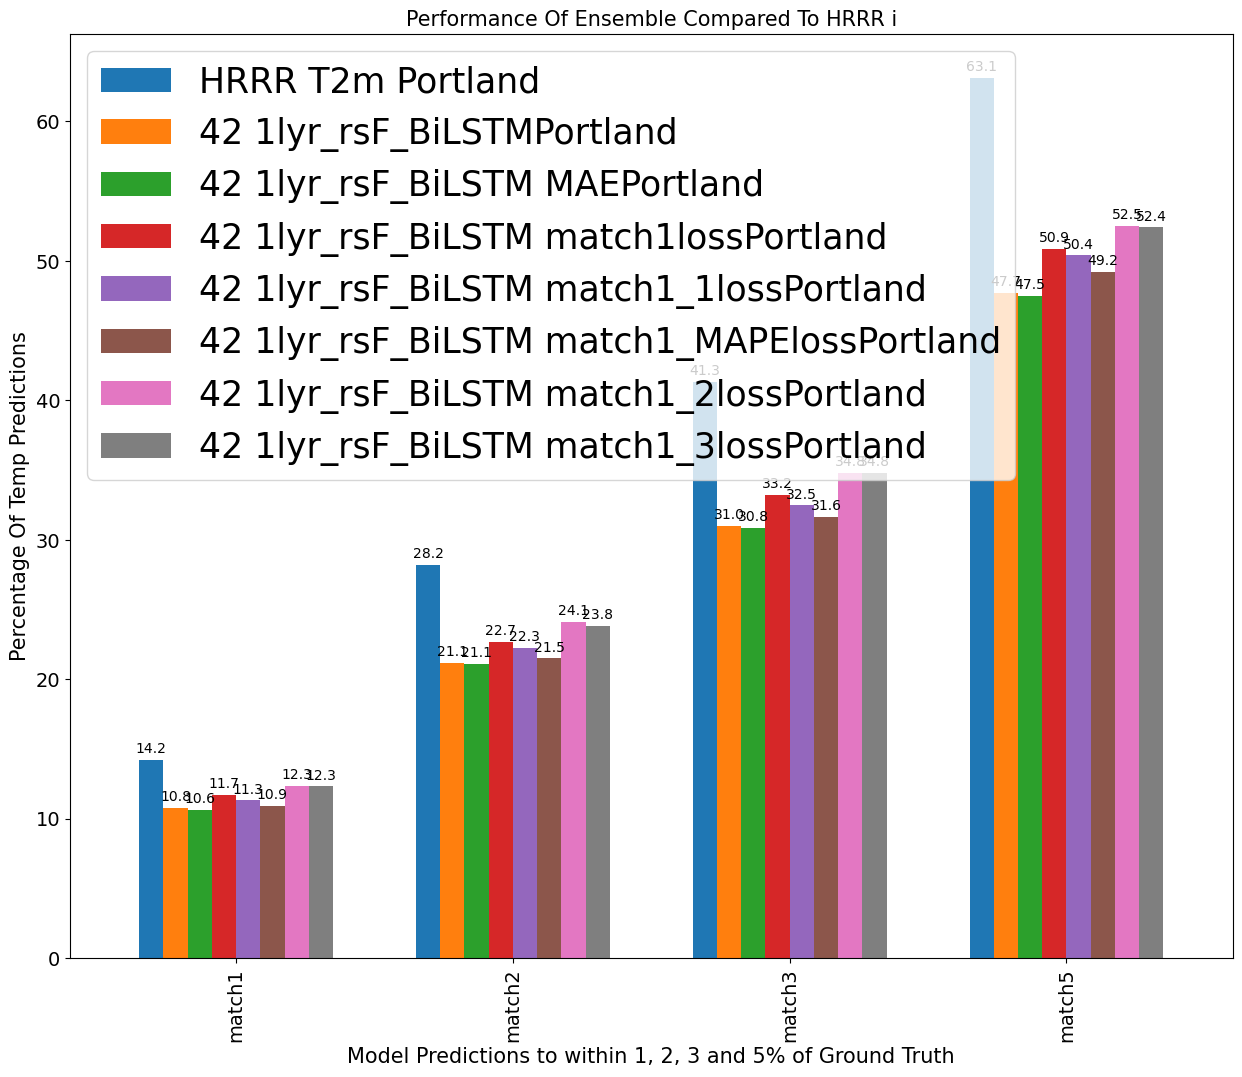

In [52]:

ax=cityperformseeddf[6:10].mul(100).plot(y=['HRRR T2m Portland','42 1lyr_rsF_BiLSTMPortland',
                                            '42 1lyr_rsF_BiLSTM MAEPortland', '42 1lyr_rsF_BiLSTM match1lossPortland',
                                           '42 1lyr_rsF_BiLSTM match1_1lossPortland', '42 1lyr_rsF_BiLSTM match1_MAPElossPortland',
                                           '42 1lyr_rsF_BiLSTM match1_2lossPortland', '42 1lyr_rsF_BiLSTM match1_3lossPortland'], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25)#,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR i", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'


In [174]:
citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", engine="pyarrow")
citycompareseeddf.columns


Index(['ERA5 T2m AlbanyNY', 'HRRR T2m AlbanyNY',
       'AlbanyNYT17loss shallow1L_1rsT_temp_unscaled_thresholdloss_BiLSTMAlbanyNY',
       'AlbanyNYT17loss conv_modelAlbanyNY',
       'AlbanyNYT17loss LSTM2lyrsTAlbanyNY',
       'AlbanyNYT17loss shallowLSTMrsFAlbanyNY'],
      dtype='object')

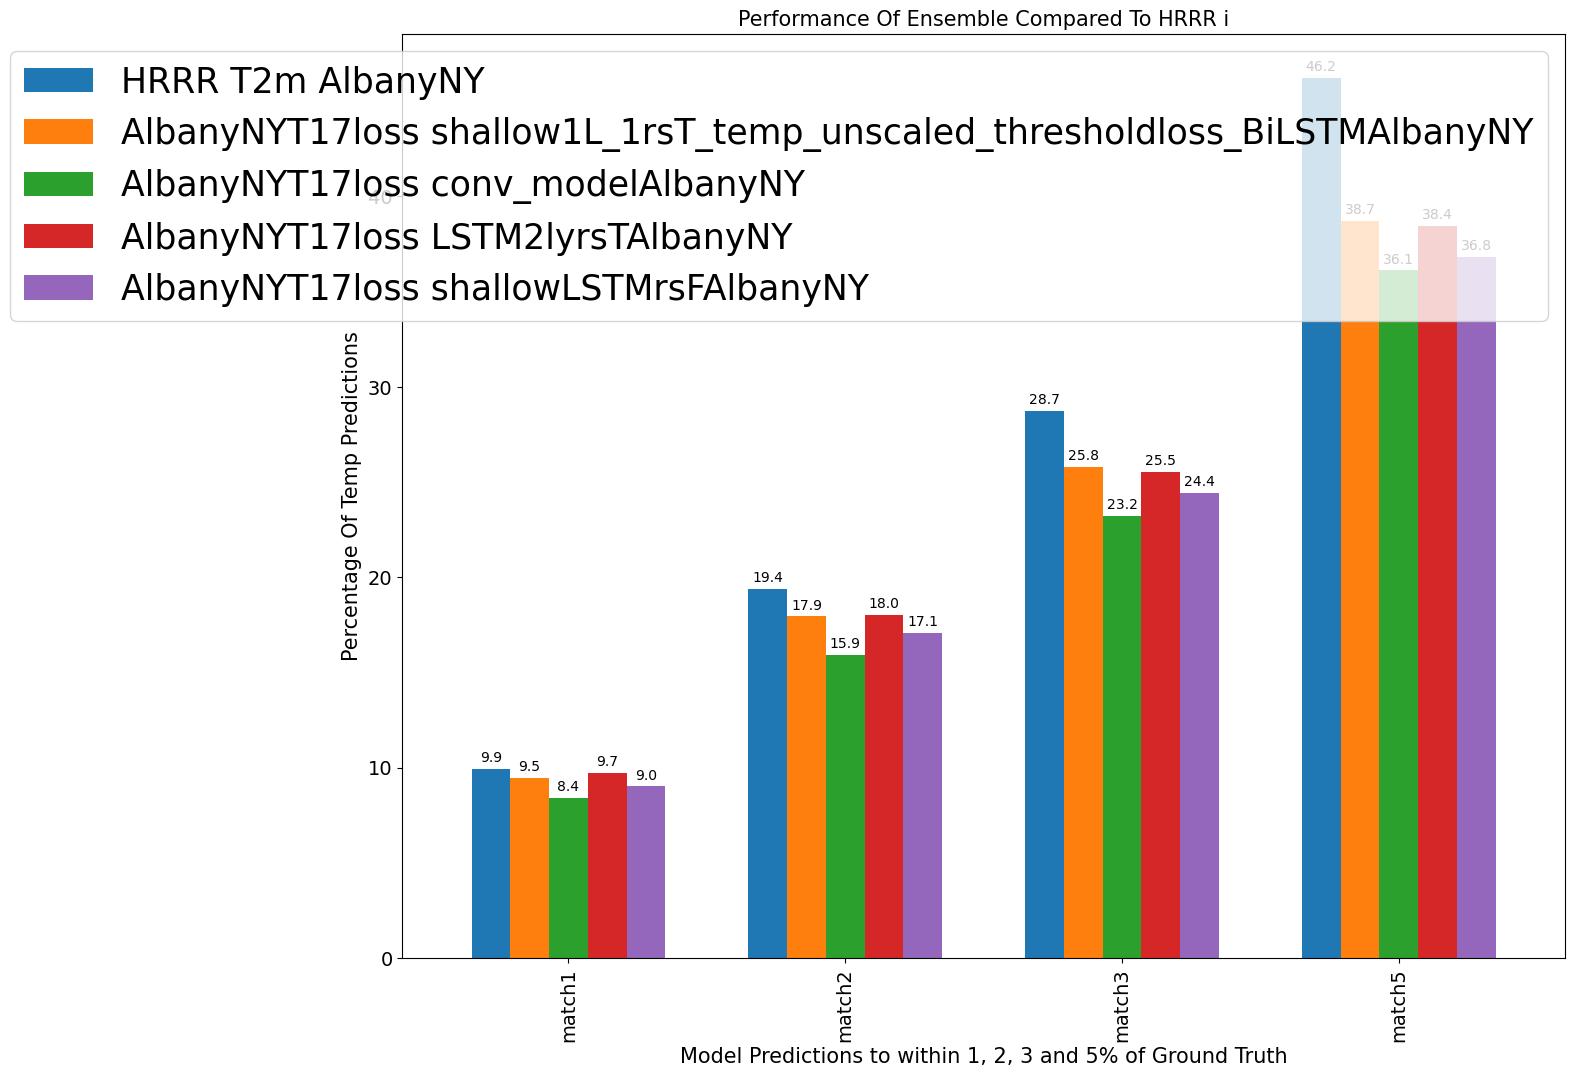

In [175]:
ax=cityperformseeddf[6:10].mul(100).plot( kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25)#,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR i", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

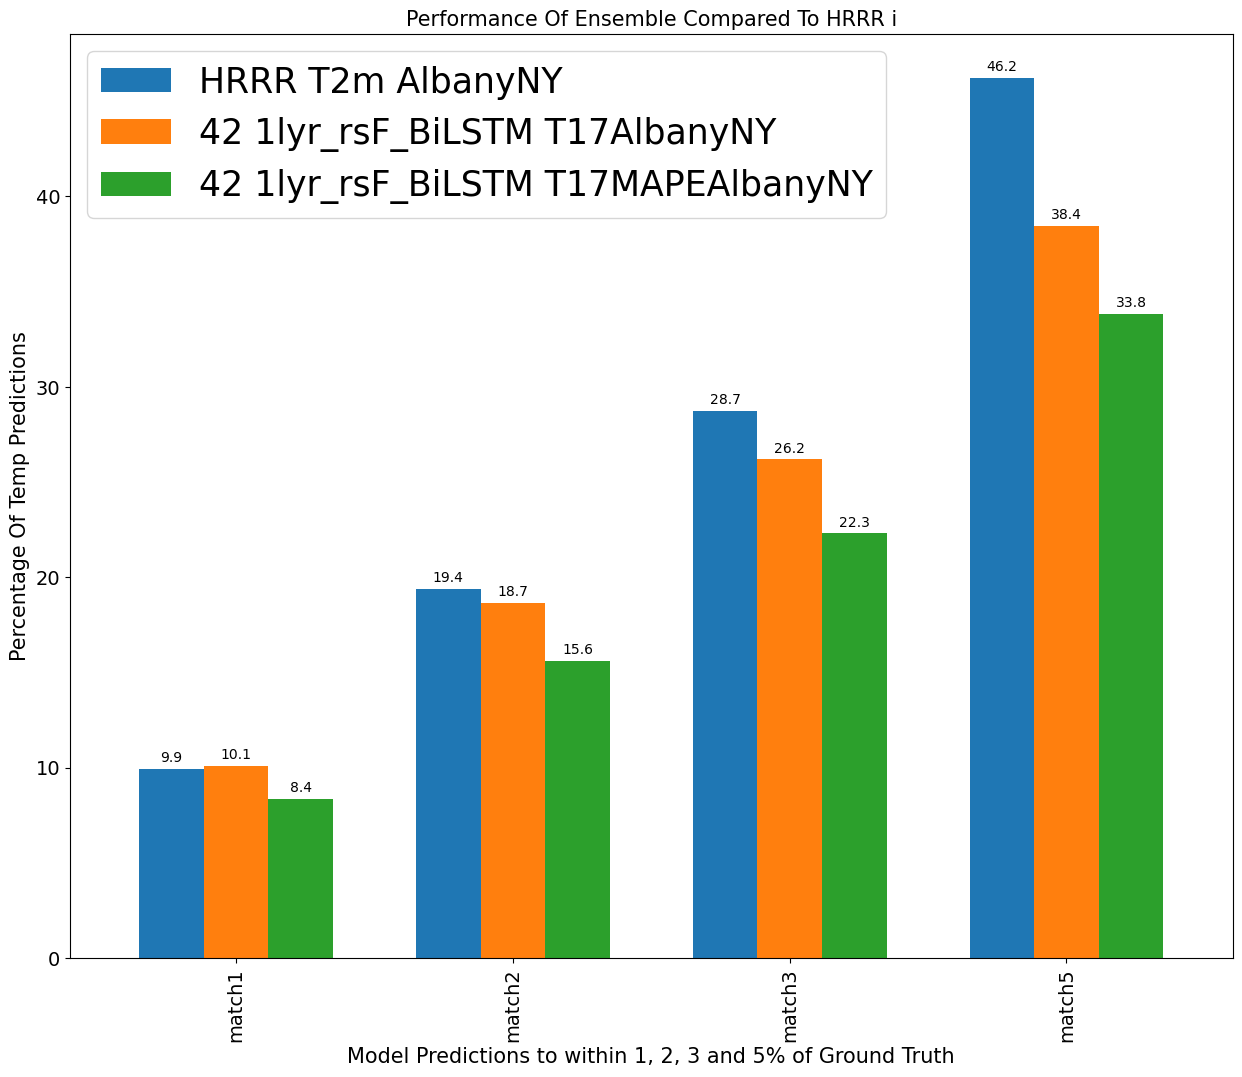

In [124]:
ax=cityperformseeddf[6:10].mul(100).plot(y=['HRRR T2m AlbanyNY',
       '42 1lyr_rsF_BiLSTM T17AlbanyNY', '42 1lyr_rsF_BiLSTM T17MAPEAlbanyNY'], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25)#,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR i", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

In [23]:
city="Portland"
citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", engine="pyarrow")
citycompareseeddf.columns

Index(['ERA5 T2m Portland', 'HRRR T2m Portland', '4 1lyr_rsF_BiLSTMPortland',
       '63 1lyr_rsF_BiLSTMPortland', '580 1lyr_rsF_BiLSTMPortland',
       '3297 1lyr_rsF_BiLSTMPortland', '883 1lyr_rsF_BiLSTMPortland',
       '2318600 1lyr_rsF_BiLSTMPortland', '970036 1lyr_rsF_BiLSTMPortland',
       '7458 1lyr_rsF_BiLSTMPortland', '65653 1lyr_rsF_BiLSTMPortland',
       '18436 1lyr_rsF_BiLSTMPortland', '1743 1lyr_rsF_BiLSTMPortland',
       '49130 1lyr_rsF_BiLSTMPortland', '42 1lyr_rsF_BiLSTMPortland',
       ' 1lyr_rsF_BiLSTMEnsemble Avg13Portland',
       '42 1lyr_rsF_BiLSTM MAEPortland', '4 1lyr_rsF_BiLSTM MAEPortland',
       '63 1lyr_rsF_BiLSTM MAEPortland', '580 1lyr_rsF_BiLSTM MAEPortland',
       '3297 1lyr_rsF_BiLSTM MAEPortland', '883 1lyr_rsF_BiLSTM MAEPortland',
       '2318600 1lyr_rsF_BiLSTM MAEPortland',
       '970036 1lyr_rsF_BiLSTM MAEPortland',
       '7458 1lyr_rsF_BiLSTM MAEPortland',
       '65653 1lyr_rsF_BiLSTM MAEPortland'],
      dtype='object')

In [31]:
Ensemblename = modelname + "Ensemble Avg13 MAE"+city #MAKE SURE IT IS CORRECT
citycompareseeddf[Ensemblename] = citycompareseeddf.iloc[:,2:].mean(axis=1)#CHANGE
strlabel= Ensemblename
citycompareseeddf_wo_nan= citycompareseeddf.dropna()
era5nonan=np.array(citycompareseeddf_wo_nan["ERA5 T2m "+city])
strlabelnonan=np.array(citycompareseeddf_wo_nan[strlabel])

cityperformseeddf[strlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                      keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                      RMSE(era5nonan, strlabelnonan).numpy(), 
                                      threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                      r2(era5nonan, strlabelnonan).numpy(), 
                                      accuracy(era5nonan, strlabelnonan).numpy(), 
                                      match1(era5nonan, strlabelnonan).numpy(), 
                                      match2(era5nonan, strlabelnonan).numpy(), 
                                      match3(era5nonan, strlabelnonan).numpy(), 
                                      match5(era5nonan, strlabelnonan).numpy()]
citycompareseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

cityperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", compression="gzip")



KeyError: "['ERA5 T2m Portland'] not in index"

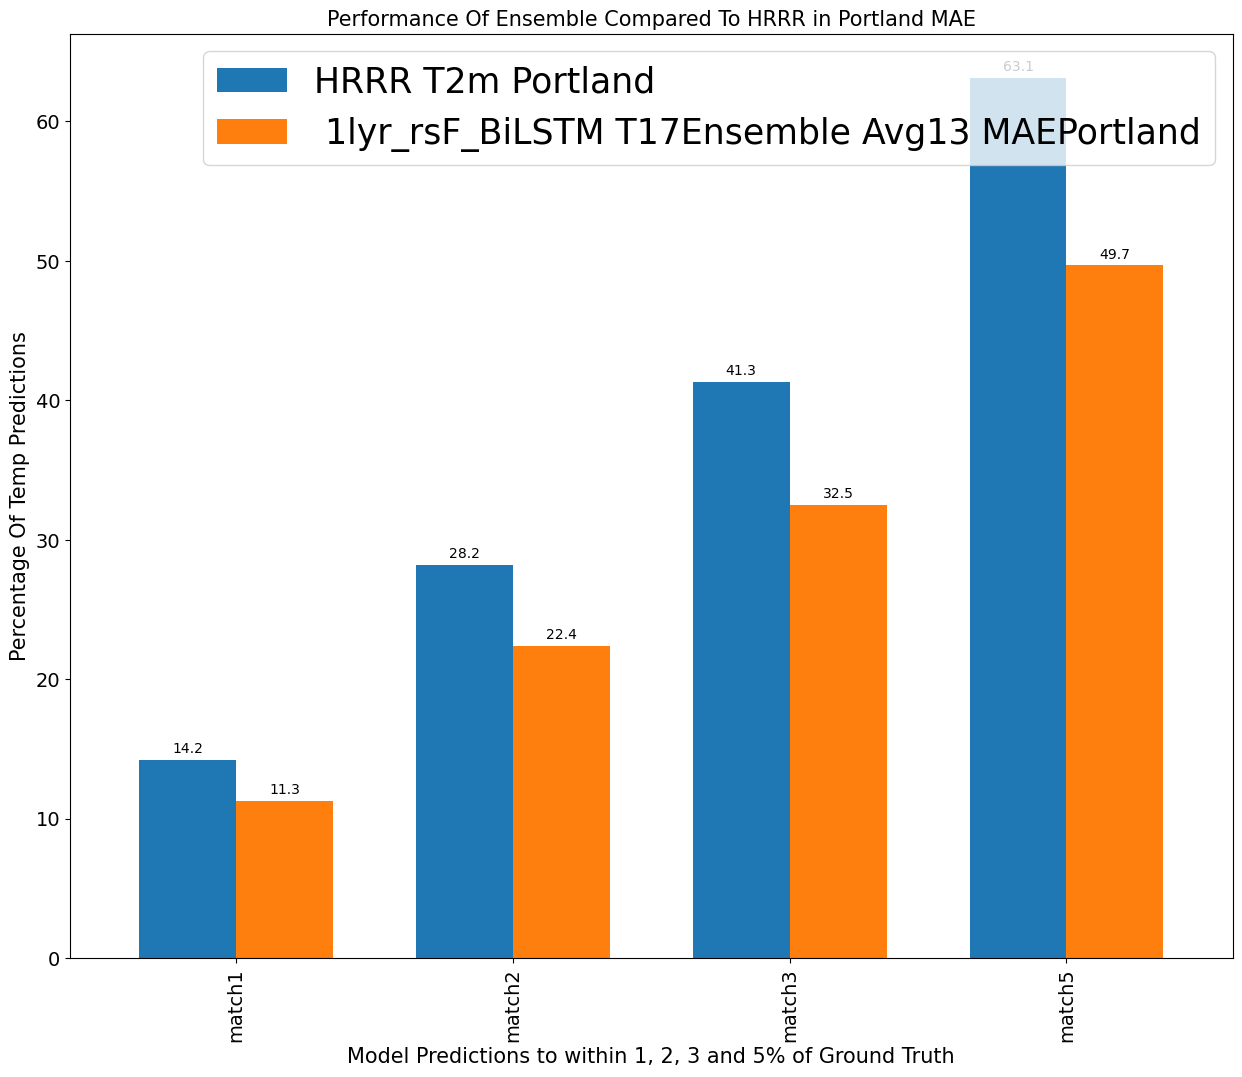

In [32]:
ax=cityperformseeddf[6:10].mul(100).plot(y=['HRRR T2m Portland',Ensemblename], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25)#,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR in Portland MAE", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

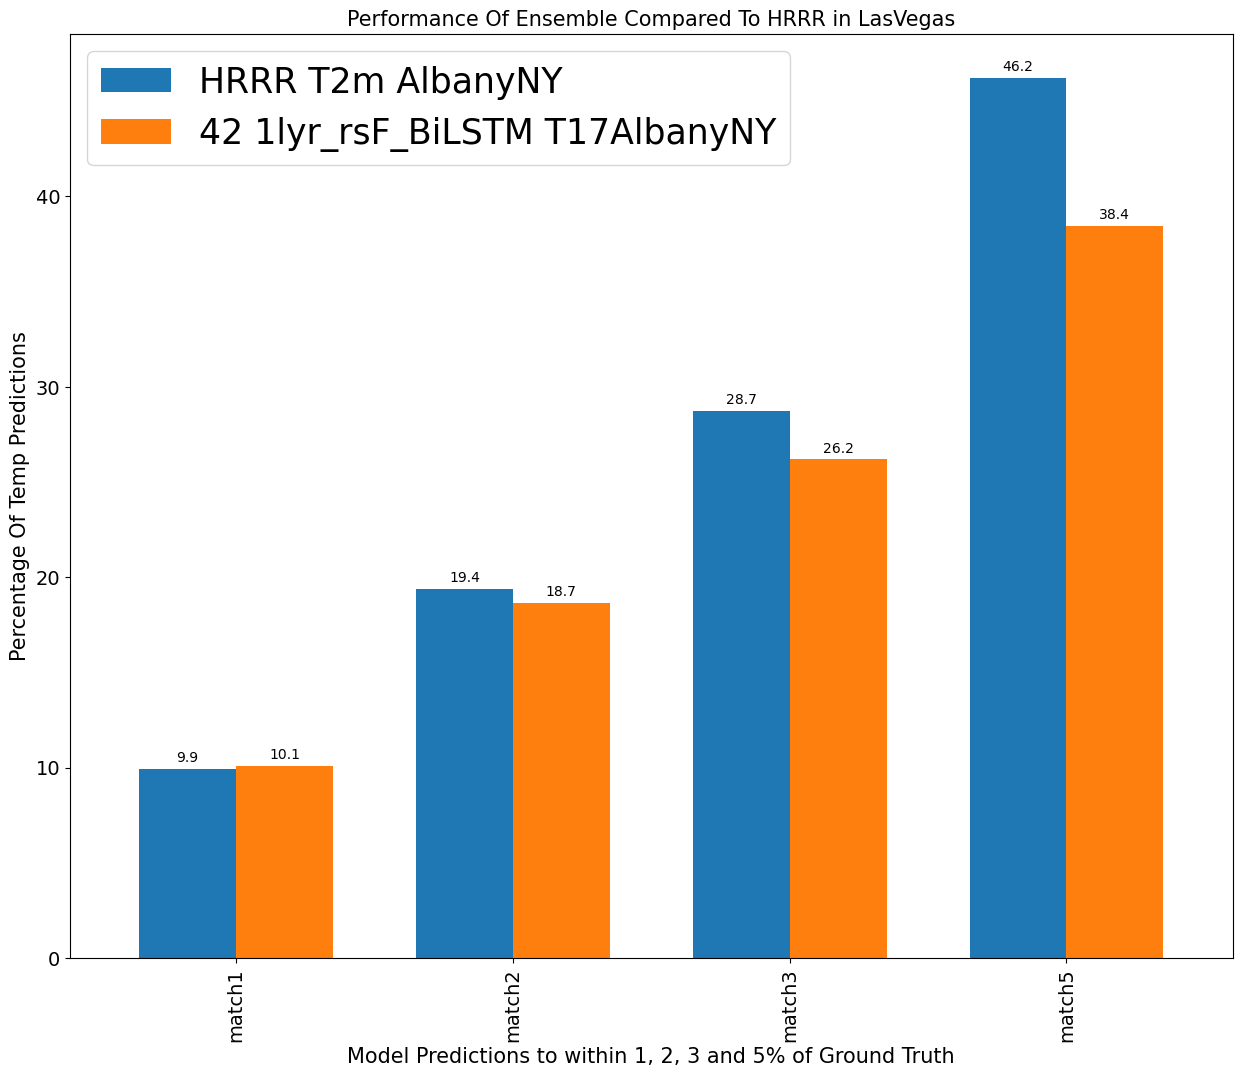

In [22]:
ax=cityperformseeddf[6:10].mul(100).plot(y=['HRRR T2m AlbanyNY','42 1lyr_rsF_BiLSTM T17AlbanyNY'], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25)#,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR in LasVegas", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

In [21]:
def Ensembleavg13creation(city):
    citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
    cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", engine="pyarrow")
    #citycompareseeddf.columns.get_loc("42 1lyr_rsF_BiLSTM"+city)#make sure it is 2
    Ensemblename = modelname + "Ensemble Avg13"+city #MAKE SURE IT IS CORRECT
    citycompareseeddf[Ensemblename] = citycompareseeddf.iloc[:,2:].mean(axis=1)#CHANGE
    strlabel= Ensemblename
    citycompareseeddf_wo_nan= citycompareseeddf.dropna()
    era5nonan=np.array(citycompareseeddf_wo_nan["ERA5 T2m "+city])
    strlabelnonan=np.array(citycompareseeddf_wo_nan[strlabel])

    cityperformseeddf[strlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                          keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                          RMSE(era5nonan, strlabelnonan).numpy(), 
                                          threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                          r2(era5nonan, strlabelnonan).numpy(), 
                                          accuracy(era5nonan, strlabelnonan).numpy(), 
                                          match1(era5nonan, strlabelnonan).numpy(), 
                                          match2(era5nonan, strlabelnonan).numpy(), 
                                          match3(era5nonan, strlabelnonan).numpy(), 
                                          match5(era5nonan, strlabelnonan).numpy()]
    citycompareseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

    cityperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet", compression="gzip")
                                  
#     ax=performseeddf[6:10].mul(100).plot(kind="bar", figsize=(15,12), width=0.7, fontsize=14)# log=True,
#     ax.legend(fontsize=12)
#     for container in ax.containers:
#         ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

Ensembleavg13creation(city)

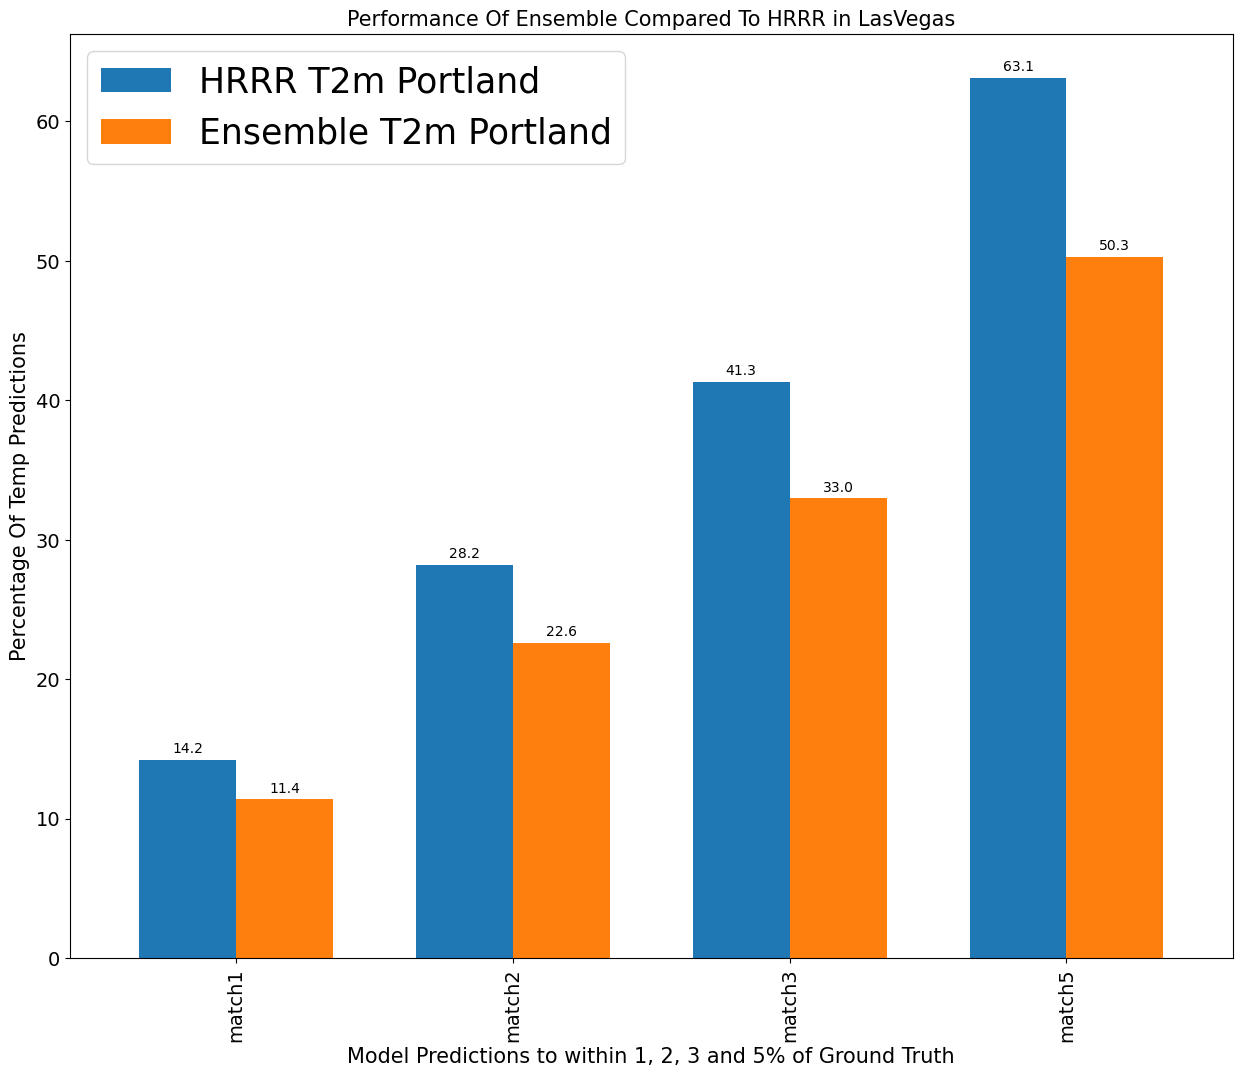

In [22]:
#GRAPHING
Ensemblename = modelname + "Ensemble Avg13"+city
cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet")

mylabels=["HRRR T2m "+city, "Ensemble T2m "+city]#,"LSTM Avg13", "Conv Avg13",
                                        #"2lyr_rsT_BiLSTM Avg13"]

ax=cityperformseeddf[6:10].mul(100).plot(y=["HRRR T2m "+city,Ensemblename], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=25,labels=mylabels)
ax.set_title("Performance Of Ensemble Compared To HRRR in LasVegas", fontsize=15 )
ax.set_xlabel("Model Predictions to within 1, 2, 3 and 5% of Ground Truth", fontsize=15 )
ax.set_ylabel("Percentage Of Temp Predictions", fontsize=15 )
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

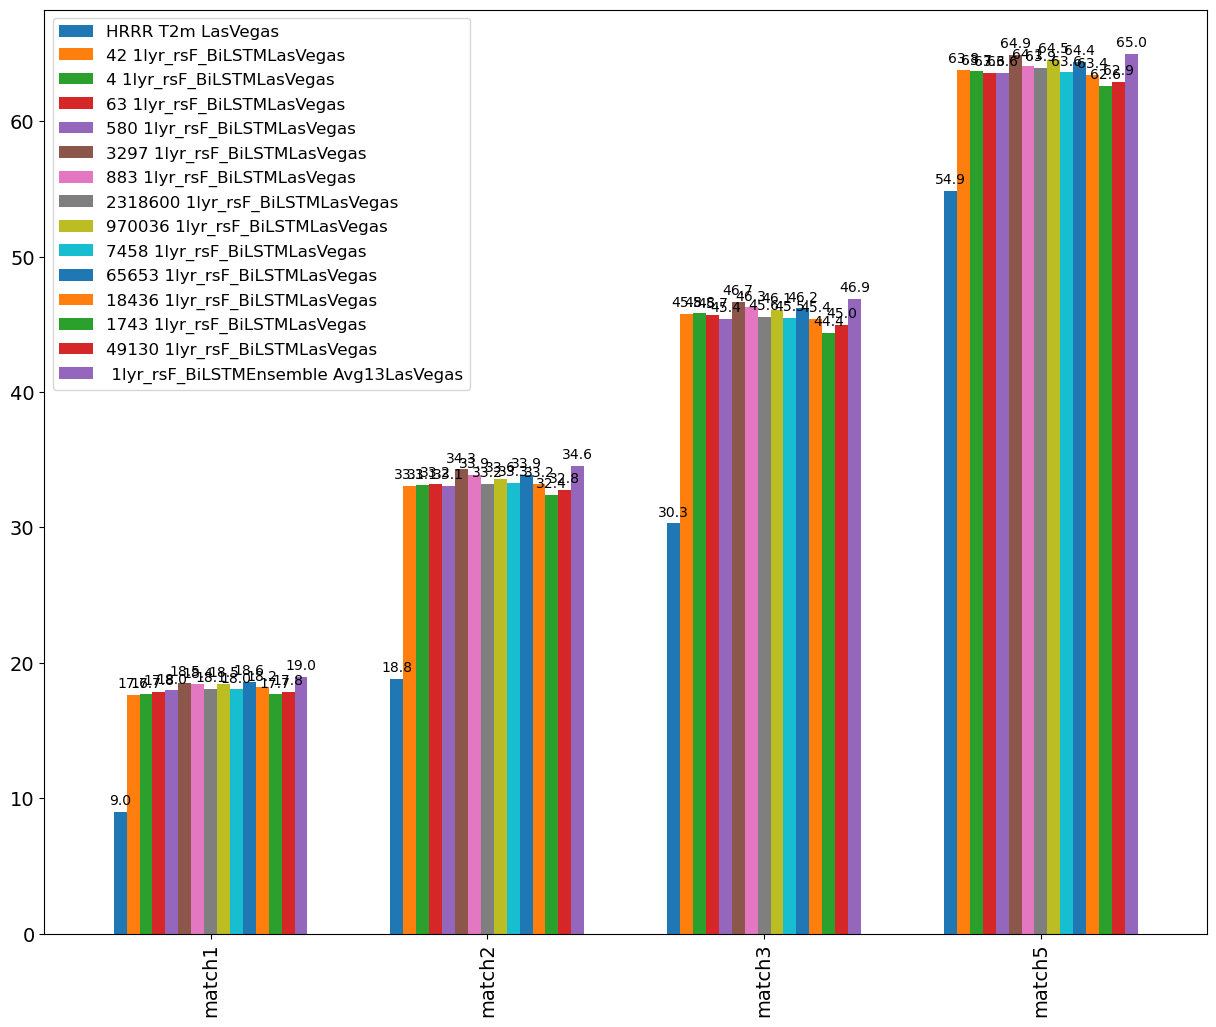

In [103]:
ax=cityperformseeddf[6:10].mul(100).plot(kind="bar", figsize=(15,12), width=0.7, fontsize=14)# log=True,
ax.legend(fontsize=12)
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

In [ ]:
#IGNORE FROM HERE:

In [19]:
#seeddf.columns# make sure it is from 32nd column
citycompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", engine="pyarrow")
cityperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRR"+city+"point_half2022.parquet")
    
citycompareseeddf.columns.get_loc("42 1lyr_rsF_BiLSTM")#make sure it is 2

2

In [20]:
citycompareseeddf.columns

Index(['ERA5 Dallas', 'HRRR Dallas', '42 1lyr_rsF_BiLSTM', '4 1lyr_rsF_BiLSTM',
       '63 1lyr_rsF_BiLSTM', '580 1lyr_rsF_BiLSTM', '3297 1lyr_rsF_BiLSTM',
       '883 1lyr_rsF_BiLSTM', '2318600 1lyr_rsF_BiLSTM',
       '970036 1lyr_rsF_BiLSTM', '7458 1lyr_rsF_BiLSTM',
       '65653 1lyr_rsF_BiLSTM', '18436 1lyr_rsF_BiLSTM',
       '1743 1lyr_rsF_BiLSTM', '49130 1lyr_rsF_BiLSTM'],
      dtype='object')

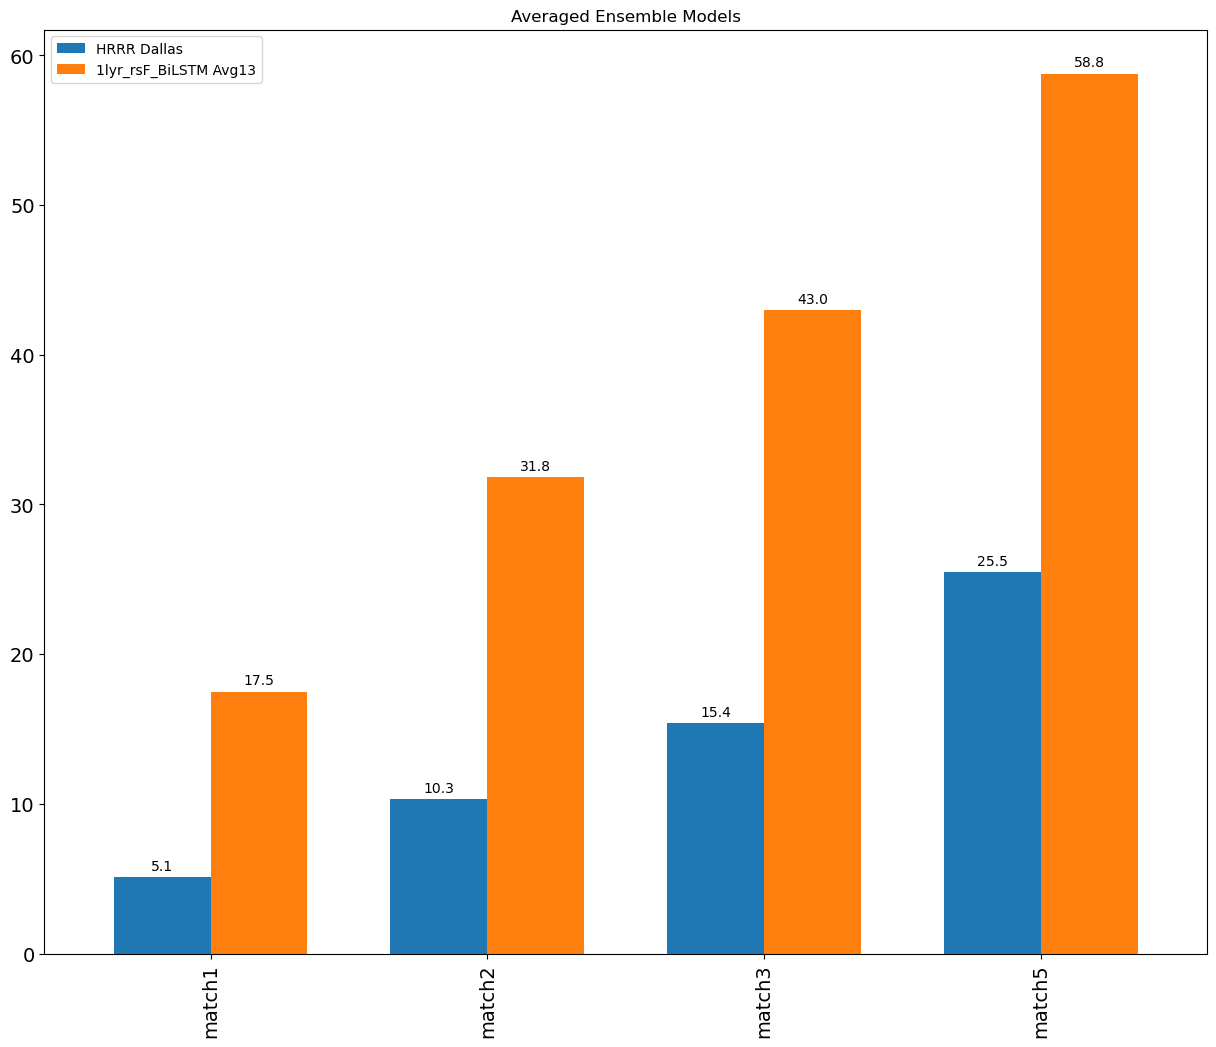

In [22]:
Ensemblename = modelname + "Ensemble Avg13"+city #MAKE SURE IT IS CORRECT
citycompareseeddf[Ensemblename] = citycompareseeddf.iloc[:,2:].mean(axis=1)#CHANGE
strlabel= Ensemblename
citycompareseeddf_wo_nan= citycompareseeddf.dropna()
era5nonan=np.array(citycompareseeddf_wo_nan["ERA5 T2m "+city])
strlabelnonan=np.array(citycompareseeddf_wo_nan[strlabel])

cityperformseeddf[strlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                      keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                      RMSE(era5nonan, strlabelnonan).numpy(), 
                                      threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                      r2(era5nonan, strlabelnonan).numpy(), 
                                      accuracy(era5nonan, strlabelnonan).numpy(), 
                                      match1(era5nonan, strlabelnonan).numpy(), 
                                      match2(era5nonan, strlabelnonan).numpy(), 
                                      match3(era5nonan, strlabelnonan).numpy(), 
                                      match5(era5nonan, strlabelnonan).numpy()]
dallasseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasseeddf.pq", compression="gzip")

dallasperformseeddf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/dallasperformseeddf.pq", compression="gzip")
      

mylabels=["HRRR", "1lyr_rsF_BiLSTM Avg13","LSTM Avg13", "Conv Avg13",
                                        "2lyr_rsT_BiLSTM Avg13"]

ax=dallasperformseeddf[6:10].mul(100).plot(y=["HRRR Dallas","1lyr_rsF_BiLSTM Avg13", Ensemblename], kind="bar",
                                     figsize=(15,12), width=0.7, fontsize=14)# log=True,y=["HRRR", "Avg13","LSTM Ensemble Avg13", "Conv Ensemble Avg13",
                                       # "2lyr_rsT_BiLSTM Avg13"],
ax.legend(fontsize=10)#labels=mylabels,
ax.set_title("Averaged Ensemble Models")
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3)#'%.2f%%'

In [ ]:
#FUNCTION FOR COMPARESEEDDF FOR NEW CITIES:
def makeINITIALCompareseed_Performseeddf(dftesthalf2022,city):
    LVcompareseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRRLasVegaspoint_half2022.parquet", engine="pyarrow")
    LVperformseeddf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRRLasVegaspoint_half2022.parquet")

    #To get era5 temp into forecast index:
    tempERA5test=dftesthalf2022[48:]["temperature_2m"]
    tempERA5test = pd.DataFrame(tempERA5test)

    arraylist=[]
    for i in range(4249):#4296 rows-48
        arraylist.extend(np.array(tempERA5test[i:i+48]))

    eradf=pd.DataFrame(arraylist,index=LVcompareseeddf.index)
    ERA5strlabel= 'ERA5 T2m '+city
    eradf.rename(columns={0: ERA5strlabel}, inplace=True)
    
    #to get HRRR; add above ERA to HRRR
    cityHRRRfilename= '/Users/sn/Downloads/nonscaled_preprocesssed_Ind/'+city+'_point_hrrr_t2m_first6Months2022.pq_gz'
    cityseed2022t2m=pd.read_parquet(cityHRRRfilename,engine='pyarrow')#should be 203952 rows × 1 columns
    cityseed2022t2m=cityseed2022t2m[:-2256]
    HRRRstrlabel= 'HRRR T2m '+city
    cityseed2022t2m.rename(columns={'t2m': HRRRstrlabel}, inplace=True)
    cityseed2022t2m[ERA5strlabel]=eradf[ERA5strlabel]
    cityseed2022t2m = cityseed2022t2m[[ERA5strlabel, HRRRstrlabel]]
    cityseed2022t2m.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRR"+city+"point_half2022.parquet", compression="gzip")

    
    #making performseeddf
    Performseeds =pd.DataFrame(index=LVperformseeddf.index)

    cityseed2022t2m_wo_nan= cityseed2022t2m.dropna()
    era5nonan=np.array(cityseed2022t2m_wo_nan[ERA5strlabel])
    strlabelnonan=np.array(cityseed2022t2m_wo_nan[HRRRstrlabel])

    Performseeds[HRRRstrlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                              keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                              RMSE(era5nonan, strlabelnonan).numpy(), 
                                              threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                              r2(era5nonan, strlabelnonan).numpy(), 
                                              accuracy(era5nonan, strlabelnonan).numpy(), 
                                              match1(era5nonan, strlabelnonan).numpy(), 
                                              match2(era5nonan, strlabelnonan).numpy(), 
                                              match3(era5nonan, strlabelnonan).numpy(), 
                                              match5(era5nonan, strlabelnonan).numpy()]
    Performseeds.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseeds_HRRR"+city+"point_half2022.parquet")
    
    


In [27]:
seeddf = seeddf.rename(columns={'Avg': 'Avg13', 'lsp_lsp_selF_T17p15_11yrtrENSEMBLE': 'sp12FT17p1511yrstacked12ENSEMBLE'})

In [66]:
#import pandas as pd
modelsdf=pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_diffmodelstfts_HRRRIndpoint_half2022.parquet", engine="pyarrow")
performmodelsdf= pd.read_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffmodelstfts_HRRRIndpoint_half2022.parquet", engine="pyarrow")
# #performmodelsdf.columns

In [69]:
performmodelsdf

,HRRRtmp,lsp_lsp,lsp_lsp_SELECTEDfeatNOTR,lsp_lsp_Transformer,lsp_lsp_bert,lsp_lsp_informer,lsp_lsp_wavenet,lsp_lsp_selF_TCN,lsp_lsp_selF_seq2seq,lsp_lsp_selF_bilstm_thrshold2loss,...,Persistence,Dense,T17loss shallow1L_1rsF_temp_unscaled_thresholdloss_BiLSTM,T17loss shallow2L_1rsT_temp_unscaled_thresholdloss_BiLSTM,T17loss conv_model,T17loss LSTM2lyrsT,T17loss shallowLSTMrsF,T17loss shallow2L_2rsF_temp_unscaled_thresholdloss_BiLSTM,Shallow BiLSTMrsF Av13 Ensemble,AutoARIMA MAE12feat
MSE,102.537029,48.624386,44.135738,99.705292,50.642544,122.872643,47.362850,57.546036,48.023937,42.578365,...,2635.700928,2635.700928,43.904423,43.218616,45.396923,45.824261,44.303894,44.032696,41.849541,718.330795
MAE,8.099148,5.178500,4.836760,7.970122,5.445236,8.834199,5.098726,5.953730,5.216013,4.772902,...,47.296364,47.296364,4.822915,4.756095,4.873461,5.022545,4.809159,4.847497,4.557201,21.833766
RMSE,10.126057,6.973119,6.643474,9.985253,7.116357,11.084793,6.882067,7.585910,6.929930,6.525210,...,51.339078,51.339078,6.626041,6.574087,6.737724,6.769362,6.656117,6.635714,6.469122,26.801694
threshold_loss,0.080991,0.051785,0.048368,0.079701,0.054452,0.088342,0.050987,0.059537,0.052160,0.047729,...,0.472964,0.472964,0.048229,0.047561,0.048735,0.050225,0.048092,0.048475,0.045572,0.218338
R2,0.742886,0.878073,0.889329,0.749987,0.873013,0.691895,0.881237,0.855702,0.879579,0.893234,...,-5.609069,-5.609069,0.889909,0.891629,0.886166,0.885095,0.888907,0.889587,0.895061,-0.801228
accuracy,5437.827148,5079.976074,5272.405762,5136.817383,5224.018066,4775.657227,5128.721191,5131.068359,5266.106934,5281.078613,...,48.295879,48.295879,5277.553711,5257.904785,5423.755371,5320.196289,5348.986816,5315.052734,5370.541016,2871.980469
match1,0.034366,0.064498,0.081033,0.039453,0.062014,0.031616,0.071325,0.048220,0.066595,0.080429,...,0.000000,0.000000,0.082853,0.081181,0.090057,0.076520,0.092501,0.081913,0.108888,0.009450
match2,0.069425,0.129213,0.161788,0.079875,0.123434,0.063053,0.141641,0.097182,0.133478,0.161106,...,0.000000,0.000000,0.166677,0.164994,0.174682,0.153605,0.179907,0.163698,0.205318,0.019296
match3,0.105682,0.195581,0.240555,0.120871,0.182816,0.095371,0.209157,0.146718,0.198025,0.239071,...,0.000000,0.000000,0.245414,0.244137,0.252687,0.227028,0.259257,0.241495,0.287201,0.029013
match5,0.178699,0.325358,0.377318,0.198817,0.300679,0.155713,0.339983,0.246067,0.324230,0.378664,...,0.000000,0.000000,0.381415,0.385244,0.385759,0.357419,0.394269,0.378060,0.418473,0.048398


In [26]:
#To get era5 temp into forecast index:
tempdallastest=dftesthalf2022[48:]["temperature_2m"]
tempdallastest = pd.DataFrame(tempdallastest)

arraylist=[]
for i in range(4249):#4296 rows-48
    arraylist.extend(np.array(tempdallastest[i:i+48]))
    
egdf=pd.DataFrame(arraylist,index=modelsdf.index)
egdf

0
time       ForecastHr            
2022-01-03 0            41.924928
           1            39.460969
           2            38.774214
           3            37.436546
           4            33.939406
...                           ...
2022-06-29 43           98.894697
           44           99.979158
           45          100.761522
           46          100.908821
           47          100.807444

[203952 rows x 1 columns]

In [27]:
egdf.rename(columns={0: 'ERA5 LV T2m'}, inplace=True)
egdf

ERA5 LV T2m
time       ForecastHr             
2022-01-03 0             41.924928
           1             39.460969
           2             38.774214
           3             37.436546
           4             33.939406
...                            ...
2022-06-29 43            98.894697
           44            99.979158
           45           100.761522
           46           100.908821
           47           100.807444

[203952 rows x 1 columns]

In [31]:
egdf[-3000:]

ERA5 LV T2m
time                ForecastHr             
2022-06-26 10:00:00 24            82.196193
                    25            81.331047
                    26            82.005552
                    27            81.374690
                    28            80.669395
...                                     ...
2022-06-29 00:00:00 43            98.894697
                    44            99.979158
                    45           100.761522
                    46           100.908821
                    47           100.807444

[3000 rows x 1 columns]

In [63]:
hrrr2022LasVegaspt=pd.read_parquet('/Users/sn/Downloads/nonscaled_preprocesssed_Ind/LasVegas_point_hrrr_t2m_first6Months2022.pq_gz',engine='pyarrow')
#hrrr2022LasVegaspt=hrrr2022LasVegaspt.reset_index()
#hrrr2022LasVegaspt= hrrr2022LasVegaspt.set_index(["time", "forecastHr","latitude","longitude"])
hrrr2022LasVegaspt=hrrr2022LasVegaspt[:-2256]
hrrr2022LasVegaspt.rename(columns={'t2m': 'HRRR LV T2m'}, inplace=True)
hrrr2022LasVegaspt

HRRR LV T2m
time       forecastHr latitude  longitude               
2022-01-03 0          36.106418 -115.163357    46.223286
           1          36.106418 -115.163357    41.214069
           2          36.106418 -115.163357    38.413322
           3          36.106418 -115.163357    35.351105
           4          36.106418 -115.163357    34.090698
...                                                  ...
2022-06-29 43         36.106418 -115.163357   102.140236
           44         36.106418 -115.163357   103.303900
           45         36.106418 -115.163357   103.961430
           46         36.106418 -115.163357   104.154960
           47         36.106418 -115.163357   103.734680

[203952 rows x 1 columns]

In [64]:
hrrr2022LasVegaspt["ERA5 LV T2m"]=egdf["ERA5 LV T2m"]
LVcomparedf = hrrr2022LasVegaspt[["ERA5 LV T2m", "HRRR LV T2m"]]
LVcomparedf

ERA5 LV T2m  HRRR LV T2m
time       forecastHr latitude  longitude                            
2022-01-03 0          36.106418 -115.163357    41.924928    46.223286
           1          36.106418 -115.163357    39.460969    41.214069
           2          36.106418 -115.163357    38.774214    38.413322
           3          36.106418 -115.163357    37.436546    35.351105
           4          36.106418 -115.163357    33.939406    34.090698
...                                                  ...          ...
2022-06-29 43         36.106418 -115.163357    98.894697   102.140236
           44         36.106418 -115.163357    99.979158   103.303900
           45         36.106418 -115.163357   100.761522   103.961430
           46         36.106418 -115.163357   100.908821   104.154960
           47         36.106418 -115.163357   100.807444   103.734680

[203952 rows x 2 columns]

In [65]:
LVcomparedf.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compare_w_era5HRRRLasVegaspoint_half2022.parquet", compression="gzip")
#this was later renamed to /Users/sn/Downloads/nonscaled_preprocesssed_Ind/Compareseeds_w_era5HRRRLasVegaspoint_half2022.parquet

In [70]:
strlabel="HRRR LV T2m"
compareLasVegasPerform =pd.DataFrame(index=performmodelsdf.index)

LVcomparedf_wo_nan= LVcomparedf.dropna()
era5nonan=np.array(LVcomparedf_wo_nan["ERA5 LV T2m"])
strlabelnonan=np.array(LVcomparedf_wo_nan[strlabel])
    
compareLasVegasPerform[strlabel]=[keras.losses.MSE(era5nonan, strlabelnonan).numpy(),
                                          keras.losses.MAE(era5nonan, strlabelnonan).numpy(), 
                                          RMSE(era5nonan, strlabelnonan).numpy(), 
                                          threshold_loss(era5nonan, strlabelnonan).numpy(), 
                                          r2(era5nonan, strlabelnonan).numpy(), 
                                          accuracy(era5nonan, strlabelnonan).numpy(), 
                                          match1(era5nonan, strlabelnonan).numpy(), 
                                          match2(era5nonan, strlabelnonan).numpy(), 
                                          match3(era5nonan, strlabelnonan).numpy(), 
                                          match5(era5nonan, strlabelnonan).numpy()]
compareLasVegasPerform

,HRRR LV T2m
MSE,15.500403
MAE,3.300966
RMSE,3.937055
threshold_loss,0.033010
R2,0.947662
accuracy,9089.191406
match1,0.090067
match2,0.187974
match3,0.302969
match5,0.548740


In [73]:
compareLasVegasPerform.to_parquet("/Users/sn/Downloads/nonscaled_preprocesssed_Ind/lsp_lsp_PERFORMANCEdiffseedsstfts_HRRRLasVegaspoint_half2022.parquet")


In [72]:
compareLasVegasPerform

,HRRR LV T2m
MSE,15.500403
MAE,3.300966
RMSE,3.937055
threshold_loss,0.033010
R2,0.947662
accuracy,9089.191406
match1,0.090067
match2,0.187974
match3,0.302969
match5,0.548740
